In [287]:
import pandas as pd
import random

import tensorflow as tf
keras = tf.keras
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import seaborn as sns

from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Lambda

from bert import bert_tokenization
from tqdm import tqdm_notebook
from tensorflow.keras import backend as K

from PIL import Image

In [290]:
# Set up
# based on: https://www.tensorflow.org/hub/tutorials/text_classification_with_tf_hub
DF_PATH = '/data/Documents/coverTheBookLover/data/goodreads-best-books/'
IMAGES_PATH = '/data/Documents/coverTheBookLover/data/goodreads-best-books/images/images/'
# bert_path = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"  # not actually used here

VAL_SIZE = 0.2

batch_size = 32

# How to get reproducible results in keras-StackOverflow
# Seed value
# Apparently you may use different seed values at each stage
RANDOM_STATE = 23

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(RANDOM_STATE)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
random.seed(RANDOM_STATE)

# 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(RANDOM_STATE)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(RANDOM_STATE)

### Data preprocessing

In [225]:
df = pd.read_csv(DF_PATH + 'book_data.csv')

In [226]:
df.head()

,book_authors,book_desc,book_edition,book_format,book_isbn,book_pages,book_rating,book_rating_count,book_review_count,book_title,genres,image_url
0,Suzanne Collins,Winning will make you famous. Losing means cer...,NaN,Hardcover,9.78044E+12,374 pages,4.33,5519135,160706,The Hunger Games,Young Adult|Fiction|Science Fiction|Dystopia|F...,https://images.gr-assets.com/books/1447303603l...
1,J.K. Rowling|Mary GrandPré,There is a door at the end of a silent corrido...,US Edition,Paperback,9.78044E+12,870 pages,4.48,2041594,33264,Harry Potter and the Order of the Phoenix,Fantasy|Young Adult|Fiction,https://images.gr-assets.com/books/1255614970l...
2,Harper Lee,The unforgettable novel of a childhood in a sl...,50th Anniversary,Paperback,9.78006E+12,324 pages,4.27,3745197,79450,To Kill a Mockingbird,Classics|Fiction|Historical|Historical Fiction...,https://images.gr-assets.com/books/1361975680l...
3,Jane Austen|Anna Quindlen|Mrs. Oliphant|George...,«È cosa ormai risaputa che a uno scapolo in po...,"Modern Library Classics, USA / CAN",Paperback,9.78068E+12,279 pages,4.25,2453620,54322,Pride and Prejudice,Classics|Fiction|Romance,https://images.gr-assets.com/books/1320399351l...
4,Stephenie Meyer,About three things I was absolutely positive.F...,NaN,Paperback,9.78032E+12,498 pages,3.58,4281268,97991,Twilight,Young Adult|Fantasy|Romance|Paranormal|Vampire...,https://images.gr-assets.com/books/1361039443l...


In [227]:
dfDescription = df[['book_desc', 'book_rating']]

In [228]:
dfDescription.head()

,book_desc,book_rating
0,Winning will make you famous. Losing means cer...,4.33
1,There is a door at the end of a silent corrido...,4.48
2,The unforgettable novel of a childhood in a sl...,4.27
3,«È cosa ormai risaputa che a uno scapolo in po...,4.25
4,About three things I was absolutely positive.F...,3.58


So some books have non English descriptions. Don't really know an easy way to drop those, so let's just hope most of them are in English.

In [229]:
dfDescription['book_desc'][0]

"Winning will make you famous. Losing means certain death.The nation of Panem, formed from a post-apocalyptic North America, is a country that consists of a wealthy Capitol region surrounded by 12 poorer districts. Early in its history, a rebellion led by a 13th district against the Capitol resulted in its destruction and the creation of an annual televised event known as the Hunger Games. In punishment, and as a reminder of the power and grace of the Capitol, each district must yield one boy and one girl between the ages of 12 and 18 through a lottery system to participate in the games. The 'tributes' are chosen during the annual Reaping and are forced to fight to the death, leaving only one survivor to claim victory.When 16-year-old Katniss's young sister, Prim, is selected as District 12's female representative, Katniss volunteers to take her place. She and her male counterpart Peeta, are pitted against bigger, stronger representatives, some of whom have trained for this their whole

In [230]:
dfDescription['book_desc'][100]

"Among the seminal texts of the 20th century, Nineteen Eighty-Four is a rare work that grows more haunting as its futuristic purgatory becomes more real. Published in 1949, the book offers political satirist George Orwell's nightmare vision of a totalitarian, bureaucratic world and one poor stiff's attempt to find individuality. The brilliance of the novel is Orwell's prescience of modern life--the ubiquity of television, the distortion of the language--and his ability to construct such a thorough version of hell. Required reading for students since it was published, it ranks among the most terrifying novels ever written."

In [231]:
# Check for books withouth desc
dfDescription['book_desc'].isna().sum()

1331

In [237]:
# drop those
dfDescription = dfDescription[dfDescription['book_desc'].notnull()].reset_index(drop=True)

Data split

In [238]:
valIndex = random.sample(range(len(dfDescription)), round(len(dfDescription)*VAL_SIZE))
trainIndex = [i for i in range(len(dfDescription)) if i not in valIndex]

train_df = dfDescription.iloc[trainIndex,]
test_df = dfDescription.iloc[valIndex,]

### Model

In [239]:
# Training input on the whole training set with no limit on training epochs.
train_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    train_df, train_df["book_rating"], num_epochs=1, shuffle=True)

# Prediction on the whole training set.
predict_train_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    train_df, train_df["book_rating"], shuffle=False)
# Prediction on the test set.
predict_test_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    test_df, test_df["book_rating"], shuffle=False)

In [240]:
embedded_text_feature_column = hub.text_embedding_column(
    key="book_desc", 
    module_spec="https://tfhub.dev/google/nnlm-en-dim128/1")

In [241]:
estimator = tf.estimator.LinearRegressor(
    feature_columns=[embedded_text_feature_column])

INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmphqqy5ryu', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f3ec473e2e8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmphqqy5ryu', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f3ec473e2e8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [242]:
MSE_train = []
MSE_test = []
epoch = []

In [243]:
epochs = 40
for i in range(epochs):
    estimator.train(input_fn=train_input_fn)
    
    train_eval_result = estimator.evaluate(input_fn=predict_train_input_fn)
    test_eval_result = estimator.evaluate(input_fn=predict_test_input_fn)
    
    MSE_train.append(train_eval_result['loss'])
    MSE_test.append(test_eval_result['loss'])
    epoch.append(i)    

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:loss = 16.491884, step = 0


INFO:tensorflow:loss = 16.491884, step = 0


INFO:tensorflow:global_step/sec: 107.091


INFO:tensorflow:global_step/sec: 107.091


INFO:tensorflow:loss = 0.99231744, step = 100 (0.935 sec)


INFO:tensorflow:loss = 0.99231744, step = 100 (0.935 sec)


INFO:tensorflow:global_step/sec: 109.837


INFO:tensorflow:global_step/sec: 109.837


INFO:tensorflow:loss = 0.3870945, step = 200 (0.910 sec)


INFO:tensorflow:loss = 0.3870945, step = 200 (0.910 sec)


INFO:tensorflow:global_step/sec: 115.224


INFO:tensorflow:global_step/sec: 115.224


INFO:tensorflow:loss = 0.27636635, step = 300 (0.868 sec)


INFO:tensorflow:loss = 0.27636635, step = 300 (0.868 sec)


INFO:tensorflow:Saving checkpoints for 332 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 332 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Loss for final step: 0.21377648.


INFO:tensorflow:Loss for final step: 0.21377648.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:11:38Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:11:38Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-332


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-332


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:11:42


INFO:tensorflow:Finished evaluation at 2020-02-14-03:11:42


INFO:tensorflow:Saving dict for global step 332: average_loss = 0.27518648, global_step = 332, label/mean = 4.0186114, loss = 0.27511227, prediction/mean = 3.8972971


INFO:tensorflow:Saving dict for global step 332: average_loss = 0.27518648, global_step = 332, label/mean = 4.0186114, loss = 0.27511227, prediction/mean = 3.8972971


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 332: /tmp/tmphqqy5ryu/model.ckpt-332


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 332: /tmp/tmphqqy5ryu/model.ckpt-332


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:11:42Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:11:42Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-332


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-332


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:11:44


INFO:tensorflow:Finished evaluation at 2020-02-14-03:11:44


INFO:tensorflow:Saving dict for global step 332: average_loss = 0.27402073, global_step = 332, label/mean = 4.0156164, loss = 0.27376533, prediction/mean = 3.8988307


INFO:tensorflow:Saving dict for global step 332: average_loss = 0.27402073, global_step = 332, label/mean = 4.0156164, loss = 0.27376533, prediction/mean = 3.8988307


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 332: /tmp/tmphqqy5ryu/model.ckpt-332


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 332: /tmp/tmphqqy5ryu/model.ckpt-332


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-332


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-332


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 332 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 332 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:loss = 0.36795565, step = 332


INFO:tensorflow:loss = 0.36795565, step = 332


INFO:tensorflow:global_step/sec: 105.189


INFO:tensorflow:global_step/sec: 105.189


INFO:tensorflow:loss = 0.17425595, step = 432 (0.952 sec)


INFO:tensorflow:loss = 0.17425595, step = 432 (0.952 sec)


INFO:tensorflow:global_step/sec: 113.355


INFO:tensorflow:global_step/sec: 113.355


INFO:tensorflow:loss = 0.16788012, step = 532 (0.882 sec)


INFO:tensorflow:loss = 0.16788012, step = 532 (0.882 sec)


INFO:tensorflow:global_step/sec: 112.442


INFO:tensorflow:global_step/sec: 112.442


INFO:tensorflow:loss = 0.10813077, step = 632 (0.889 sec)


INFO:tensorflow:loss = 0.10813077, step = 632 (0.889 sec)


INFO:tensorflow:Saving checkpoints for 664 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 664 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Loss for final step: 0.10313844.


INFO:tensorflow:Loss for final step: 0.10313844.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:12:10Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:12:10Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-664


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-664


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:12:14


INFO:tensorflow:Finished evaluation at 2020-02-14-03:12:14


INFO:tensorflow:Saving dict for global step 664: average_loss = 0.15568429, global_step = 664, label/mean = 4.0186114, loss = 0.15596683, prediction/mean = 4.051427


INFO:tensorflow:Saving dict for global step 664: average_loss = 0.15568429, global_step = 664, label/mean = 4.0186114, loss = 0.15596683, prediction/mean = 4.051427


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 664: /tmp/tmphqqy5ryu/model.ckpt-664


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 664: /tmp/tmphqqy5ryu/model.ckpt-664


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:12:14Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:12:14Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-664


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-664


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:12:16


INFO:tensorflow:Finished evaluation at 2020-02-14-03:12:16


INFO:tensorflow:Saving dict for global step 664: average_loss = 0.15370002, global_step = 664, label/mean = 4.0156164, loss = 0.15354232, prediction/mean = 4.0518694


INFO:tensorflow:Saving dict for global step 664: average_loss = 0.15370002, global_step = 664, label/mean = 4.0156164, loss = 0.15354232, prediction/mean = 4.0518694


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 664: /tmp/tmphqqy5ryu/model.ckpt-664


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 664: /tmp/tmphqqy5ryu/model.ckpt-664


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-664


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-664


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 664 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 664 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:loss = 0.13134211, step = 664


INFO:tensorflow:loss = 0.13134211, step = 664


INFO:tensorflow:global_step/sec: 112.308


INFO:tensorflow:global_step/sec: 112.308


INFO:tensorflow:loss = 0.094510466, step = 764 (0.892 sec)


INFO:tensorflow:loss = 0.094510466, step = 764 (0.892 sec)


INFO:tensorflow:global_step/sec: 111.668


INFO:tensorflow:global_step/sec: 111.668


INFO:tensorflow:loss = 0.31268987, step = 864 (0.896 sec)


INFO:tensorflow:loss = 0.31268987, step = 864 (0.896 sec)


INFO:tensorflow:global_step/sec: 109.774


INFO:tensorflow:global_step/sec: 109.774


INFO:tensorflow:loss = 0.13275865, step = 964 (0.911 sec)


INFO:tensorflow:loss = 0.13275865, step = 964 (0.911 sec)


INFO:tensorflow:Saving checkpoints for 996 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 996 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Loss for final step: 0.033429146.


INFO:tensorflow:Loss for final step: 0.033429146.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:12:30Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:12:30Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-996


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-996


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:12:34


INFO:tensorflow:Finished evaluation at 2020-02-14-03:12:34


INFO:tensorflow:Saving dict for global step 996: average_loss = 0.12595728, global_step = 996, label/mean = 4.0186114, loss = 0.1259285, prediction/mean = 3.9614205


INFO:tensorflow:Saving dict for global step 996: average_loss = 0.12595728, global_step = 996, label/mean = 4.0186114, loss = 0.1259285, prediction/mean = 3.9614205


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 996: /tmp/tmphqqy5ryu/model.ckpt-996


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 996: /tmp/tmphqqy5ryu/model.ckpt-996


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:12:34Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:12:34Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-996


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-996


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:12:36


INFO:tensorflow:Finished evaluation at 2020-02-14-03:12:36


INFO:tensorflow:Saving dict for global step 996: average_loss = 0.122843765, global_step = 996, label/mean = 4.0156164, loss = 0.122730896, prediction/mean = 3.9609253


INFO:tensorflow:Saving dict for global step 996: average_loss = 0.122843765, global_step = 996, label/mean = 4.0156164, loss = 0.122730896, prediction/mean = 3.9609253


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 996: /tmp/tmphqqy5ryu/model.ckpt-996


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 996: /tmp/tmphqqy5ryu/model.ckpt-996


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-996


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-996


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 996 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 996 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:loss = 0.26136124, step = 996


INFO:tensorflow:loss = 0.26136124, step = 996


INFO:tensorflow:global_step/sec: 109.522


INFO:tensorflow:global_step/sec: 109.522


INFO:tensorflow:loss = 0.10099082, step = 1096 (0.914 sec)


INFO:tensorflow:loss = 0.10099082, step = 1096 (0.914 sec)


INFO:tensorflow:global_step/sec: 114.711


INFO:tensorflow:global_step/sec: 114.711


INFO:tensorflow:loss = 0.0601972, step = 1196 (0.872 sec)


INFO:tensorflow:loss = 0.0601972, step = 1196 (0.872 sec)


INFO:tensorflow:global_step/sec: 110.423


INFO:tensorflow:global_step/sec: 110.423


INFO:tensorflow:loss = 0.108966604, step = 1296 (0.905 sec)


INFO:tensorflow:loss = 0.108966604, step = 1296 (0.905 sec)


INFO:tensorflow:Saving checkpoints for 1328 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1328 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Loss for final step: 0.13153371.


INFO:tensorflow:Loss for final step: 0.13153371.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:12:53Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:12:53Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-1328


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-1328


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:12:57


INFO:tensorflow:Finished evaluation at 2020-02-14-03:12:57


INFO:tensorflow:Saving dict for global step 1328: average_loss = 0.12021898, global_step = 1328, label/mean = 4.0186114, loss = 0.12031526, prediction/mean = 4.0427732


INFO:tensorflow:Saving dict for global step 1328: average_loss = 0.12021898, global_step = 1328, label/mean = 4.0186114, loss = 0.12031526, prediction/mean = 4.0427732


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1328: /tmp/tmphqqy5ryu/model.ckpt-1328


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1328: /tmp/tmphqqy5ryu/model.ckpt-1328


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:12:57Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:12:57Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-1328


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-1328


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:12:59


INFO:tensorflow:Finished evaluation at 2020-02-14-03:12:59


INFO:tensorflow:Saving dict for global step 1328: average_loss = 0.117277525, global_step = 1328, label/mean = 4.0156164, loss = 0.11717152, prediction/mean = 4.04274


INFO:tensorflow:Saving dict for global step 1328: average_loss = 0.117277525, global_step = 1328, label/mean = 4.0156164, loss = 0.11717152, prediction/mean = 4.04274


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1328: /tmp/tmphqqy5ryu/model.ckpt-1328


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1328: /tmp/tmphqqy5ryu/model.ckpt-1328


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-1328


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-1328


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 1328 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1328 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:loss = 0.09191184, step = 1328


INFO:tensorflow:loss = 0.09191184, step = 1328


INFO:tensorflow:global_step/sec: 108.52


INFO:tensorflow:global_step/sec: 108.52


INFO:tensorflow:loss = 0.05622743, step = 1428 (0.923 sec)


INFO:tensorflow:loss = 0.05622743, step = 1428 (0.923 sec)


INFO:tensorflow:global_step/sec: 107.953


INFO:tensorflow:global_step/sec: 107.953


INFO:tensorflow:loss = 0.11179262, step = 1528 (0.926 sec)


INFO:tensorflow:loss = 0.11179262, step = 1528 (0.926 sec)


INFO:tensorflow:global_step/sec: 111.276


INFO:tensorflow:global_step/sec: 111.276


INFO:tensorflow:loss = 0.076389134, step = 1628 (0.899 sec)


INFO:tensorflow:loss = 0.076389134, step = 1628 (0.899 sec)


INFO:tensorflow:Saving checkpoints for 1660 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1660 into /tmp/tmphqqy5ryu/model.ckpt.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


INFO:tensorflow:Loss for final step: 0.15814276.


INFO:tensorflow:Loss for final step: 0.15814276.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:13:13Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:13:13Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-1660


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-1660


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:13:17


INFO:tensorflow:Finished evaluation at 2020-02-14-03:13:17


INFO:tensorflow:Saving dict for global step 1660: average_loss = 0.11925791, global_step = 1660, label/mean = 4.0186114, loss = 0.119310044, prediction/mean = 4.017192


INFO:tensorflow:Saving dict for global step 1660: average_loss = 0.11925791, global_step = 1660, label/mean = 4.0186114, loss = 0.119310044, prediction/mean = 4.017192


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1660: /tmp/tmphqqy5ryu/model.ckpt-1660


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1660: /tmp/tmphqqy5ryu/model.ckpt-1660


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:13:19Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:13:19Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-1660


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-1660


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:13:21


INFO:tensorflow:Finished evaluation at 2020-02-14-03:13:21


INFO:tensorflow:Saving dict for global step 1660: average_loss = 0.11617501, global_step = 1660, label/mean = 4.0156164, loss = 0.11605829, prediction/mean = 4.016276


INFO:tensorflow:Saving dict for global step 1660: average_loss = 0.11617501, global_step = 1660, label/mean = 4.0156164, loss = 0.11605829, prediction/mean = 4.016276


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1660: /tmp/tmphqqy5ryu/model.ckpt-1660


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1660: /tmp/tmphqqy5ryu/model.ckpt-1660


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-1660


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-1660


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 1660 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1660 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:loss = 0.23133777, step = 1660


INFO:tensorflow:loss = 0.23133777, step = 1660


INFO:tensorflow:global_step/sec: 107.248


INFO:tensorflow:global_step/sec: 107.248


INFO:tensorflow:loss = 0.0890808, step = 1760 (0.935 sec)


INFO:tensorflow:loss = 0.0890808, step = 1760 (0.935 sec)


INFO:tensorflow:global_step/sec: 116.818


INFO:tensorflow:global_step/sec: 116.818


INFO:tensorflow:loss = 0.0619262, step = 1860 (0.855 sec)


INFO:tensorflow:loss = 0.0619262, step = 1860 (0.855 sec)


INFO:tensorflow:global_step/sec: 110.958


INFO:tensorflow:global_step/sec: 110.958


INFO:tensorflow:loss = 0.41790798, step = 1960 (0.902 sec)


INFO:tensorflow:loss = 0.41790798, step = 1960 (0.902 sec)


INFO:tensorflow:Saving checkpoints for 1992 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1992 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Loss for final step: 0.07315375.


INFO:tensorflow:Loss for final step: 0.07315375.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:13:33Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:13:33Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-1992


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-1992


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:13:37


INFO:tensorflow:Finished evaluation at 2020-02-14-03:13:37


INFO:tensorflow:Saving dict for global step 1992: average_loss = 0.12068641, global_step = 1992, label/mean = 4.0186114, loss = 0.1207797, prediction/mean = 4.0404077


INFO:tensorflow:Saving dict for global step 1992: average_loss = 0.12068641, global_step = 1992, label/mean = 4.0186114, loss = 0.1207797, prediction/mean = 4.0404077


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1992: /tmp/tmphqqy5ryu/model.ckpt-1992


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1992: /tmp/tmphqqy5ryu/model.ckpt-1992


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:13:37Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:13:37Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-1992


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-1992


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:13:40


INFO:tensorflow:Finished evaluation at 2020-02-14-03:13:40


INFO:tensorflow:Saving dict for global step 1992: average_loss = 0.118123315, global_step = 1992, label/mean = 4.0156164, loss = 0.1180209, prediction/mean = 4.0404167


INFO:tensorflow:Saving dict for global step 1992: average_loss = 0.118123315, global_step = 1992, label/mean = 4.0156164, loss = 0.1180209, prediction/mean = 4.0404167


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1992: /tmp/tmphqqy5ryu/model.ckpt-1992


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1992: /tmp/tmphqqy5ryu/model.ckpt-1992


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-1992


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-1992


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 1992 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1992 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:loss = 0.093433194, step = 1992


INFO:tensorflow:loss = 0.093433194, step = 1992


INFO:tensorflow:global_step/sec: 109.101


INFO:tensorflow:global_step/sec: 109.101


INFO:tensorflow:loss = 0.08635056, step = 2092 (0.918 sec)


INFO:tensorflow:loss = 0.08635056, step = 2092 (0.918 sec)


INFO:tensorflow:global_step/sec: 112.287


INFO:tensorflow:global_step/sec: 112.287


INFO:tensorflow:loss = 0.062444486, step = 2192 (0.891 sec)


INFO:tensorflow:loss = 0.062444486, step = 2192 (0.891 sec)


INFO:tensorflow:global_step/sec: 110.039


INFO:tensorflow:global_step/sec: 110.039


INFO:tensorflow:loss = 0.10631303, step = 2292 (0.909 sec)


INFO:tensorflow:loss = 0.10631303, step = 2292 (0.909 sec)


INFO:tensorflow:Saving checkpoints for 2324 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2324 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Loss for final step: 0.16006541.


INFO:tensorflow:Loss for final step: 0.16006541.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:13:51Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:13:51Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-2324


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-2324


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:13:56


INFO:tensorflow:Finished evaluation at 2020-02-14-03:13:56


INFO:tensorflow:Saving dict for global step 2324: average_loss = 0.13045777, global_step = 2324, label/mean = 4.0186114, loss = 0.13025273, prediction/mean = 3.9090483


INFO:tensorflow:Saving dict for global step 2324: average_loss = 0.13045777, global_step = 2324, label/mean = 4.0186114, loss = 0.13025273, prediction/mean = 3.9090483


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2324: /tmp/tmphqqy5ryu/model.ckpt-2324


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2324: /tmp/tmphqqy5ryu/model.ckpt-2324


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:13:56Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:13:56Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-2324


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-2324


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:13:58


INFO:tensorflow:Finished evaluation at 2020-02-14-03:13:58


INFO:tensorflow:Saving dict for global step 2324: average_loss = 0.12669937, global_step = 2324, label/mean = 4.0156164, loss = 0.12660123, prediction/mean = 3.908297


INFO:tensorflow:Saving dict for global step 2324: average_loss = 0.12669937, global_step = 2324, label/mean = 4.0156164, loss = 0.12660123, prediction/mean = 3.908297


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2324: /tmp/tmphqqy5ryu/model.ckpt-2324


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2324: /tmp/tmphqqy5ryu/model.ckpt-2324


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-2324


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-2324


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 2324 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2324 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:loss = 0.08004312, step = 2324


INFO:tensorflow:loss = 0.08004312, step = 2324


INFO:tensorflow:global_step/sec: 110.129


INFO:tensorflow:global_step/sec: 110.129


INFO:tensorflow:loss = 0.059561204, step = 2424 (0.909 sec)


INFO:tensorflow:loss = 0.059561204, step = 2424 (0.909 sec)


INFO:tensorflow:global_step/sec: 112.925


INFO:tensorflow:global_step/sec: 112.925


INFO:tensorflow:loss = 0.25125238, step = 2524 (0.886 sec)


INFO:tensorflow:loss = 0.25125238, step = 2524 (0.886 sec)


INFO:tensorflow:global_step/sec: 110.232


INFO:tensorflow:global_step/sec: 110.232


INFO:tensorflow:loss = 0.0908676, step = 2624 (0.907 sec)


INFO:tensorflow:loss = 0.0908676, step = 2624 (0.907 sec)


INFO:tensorflow:Saving checkpoints for 2656 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2656 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Loss for final step: 0.21111058.


INFO:tensorflow:Loss for final step: 0.21111058.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:14:09Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:14:09Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-2656


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-2656


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:14:13


INFO:tensorflow:Finished evaluation at 2020-02-14-03:14:13


INFO:tensorflow:Saving dict for global step 2656: average_loss = 0.14151667, global_step = 2656, label/mean = 4.0186114, loss = 0.1418504, prediction/mean = 4.1531334


INFO:tensorflow:Saving dict for global step 2656: average_loss = 0.14151667, global_step = 2656, label/mean = 4.0186114, loss = 0.1418504, prediction/mean = 4.1531334


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2656: /tmp/tmphqqy5ryu/model.ckpt-2656


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2656: /tmp/tmphqqy5ryu/model.ckpt-2656


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:14:13Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:14:13Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-2656


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-2656


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:14:15


INFO:tensorflow:Finished evaluation at 2020-02-14-03:14:15


INFO:tensorflow:Saving dict for global step 2656: average_loss = 0.13942811, global_step = 2656, label/mean = 4.0156164, loss = 0.13932243, prediction/mean = 4.153559


INFO:tensorflow:Saving dict for global step 2656: average_loss = 0.13942811, global_step = 2656, label/mean = 4.0156164, loss = 0.13932243, prediction/mean = 4.153559


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2656: /tmp/tmphqqy5ryu/model.ckpt-2656


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2656: /tmp/tmphqqy5ryu/model.ckpt-2656


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-2656


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-2656


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 2656 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2656 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:loss = 0.12268283, step = 2656


INFO:tensorflow:loss = 0.12268283, step = 2656


INFO:tensorflow:global_step/sec: 106.436


INFO:tensorflow:global_step/sec: 106.436


INFO:tensorflow:loss = 0.094010934, step = 2756 (0.941 sec)


INFO:tensorflow:loss = 0.094010934, step = 2756 (0.941 sec)


INFO:tensorflow:global_step/sec: 113.718


INFO:tensorflow:global_step/sec: 113.718


INFO:tensorflow:loss = 0.064581774, step = 2856 (0.879 sec)


INFO:tensorflow:loss = 0.064581774, step = 2856 (0.879 sec)


INFO:tensorflow:global_step/sec: 111.938


INFO:tensorflow:global_step/sec: 111.938


INFO:tensorflow:loss = 0.118850246, step = 2956 (0.894 sec)


INFO:tensorflow:loss = 0.118850246, step = 2956 (0.894 sec)


INFO:tensorflow:Saving checkpoints for 2988 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2988 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Loss for final step: 0.07893054.


INFO:tensorflow:Loss for final step: 0.07893054.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:14:25Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:14:25Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-2988


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-2988


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:14:29


INFO:tensorflow:Finished evaluation at 2020-02-14-03:14:29


INFO:tensorflow:Saving dict for global step 2988: average_loss = 0.11925354, global_step = 2988, label/mean = 4.0186114, loss = 0.11919986, prediction/mean = 4.013437


INFO:tensorflow:Saving dict for global step 2988: average_loss = 0.11925354, global_step = 2988, label/mean = 4.0186114, loss = 0.11919986, prediction/mean = 4.013437


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2988: /tmp/tmphqqy5ryu/model.ckpt-2988


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2988: /tmp/tmphqqy5ryu/model.ckpt-2988


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:14:29Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:14:29Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-2988


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-2988


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:14:31


INFO:tensorflow:Finished evaluation at 2020-02-14-03:14:31


INFO:tensorflow:Saving dict for global step 2988: average_loss = 0.116176695, global_step = 2988, label/mean = 4.0156164, loss = 0.11606751, prediction/mean = 4.013012


INFO:tensorflow:Saving dict for global step 2988: average_loss = 0.116176695, global_step = 2988, label/mean = 4.0156164, loss = 0.11606751, prediction/mean = 4.013012


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2988: /tmp/tmphqqy5ryu/model.ckpt-2988


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2988: /tmp/tmphqqy5ryu/model.ckpt-2988


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-2988


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-2988


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 2988 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2988 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:loss = 0.29521096, step = 2988


INFO:tensorflow:loss = 0.29521096, step = 2988


INFO:tensorflow:global_step/sec: 107.448


INFO:tensorflow:global_step/sec: 107.448


INFO:tensorflow:loss = 0.117355615, step = 3088 (0.934 sec)


INFO:tensorflow:loss = 0.117355615, step = 3088 (0.934 sec)


INFO:tensorflow:global_step/sec: 115.665


INFO:tensorflow:global_step/sec: 115.665


INFO:tensorflow:loss = 0.07435753, step = 3188 (0.863 sec)


INFO:tensorflow:loss = 0.07435753, step = 3188 (0.863 sec)


INFO:tensorflow:global_step/sec: 111.44


INFO:tensorflow:global_step/sec: 111.44


INFO:tensorflow:loss = 0.06434724, step = 3288 (0.897 sec)


INFO:tensorflow:loss = 0.06434724, step = 3288 (0.897 sec)


INFO:tensorflow:Saving checkpoints for 3320 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 3320 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Loss for final step: 0.31793237.


INFO:tensorflow:Loss for final step: 0.31793237.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:14:40Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:14:40Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-3320


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-3320


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:14:44


INFO:tensorflow:Finished evaluation at 2020-02-14-03:14:44


INFO:tensorflow:Saving dict for global step 3320: average_loss = 0.12840061, global_step = 3320, label/mean = 4.0186114, loss = 0.12863974, prediction/mean = 4.1144824


INFO:tensorflow:Saving dict for global step 3320: average_loss = 0.12840061, global_step = 3320, label/mean = 4.0186114, loss = 0.12863974, prediction/mean = 4.1144824


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3320: /tmp/tmphqqy5ryu/model.ckpt-3320


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3320: /tmp/tmphqqy5ryu/model.ckpt-3320


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:14:44Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:14:44Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-3320


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-3320


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:14:46


INFO:tensorflow:Finished evaluation at 2020-02-14-03:14:46


INFO:tensorflow:Saving dict for global step 3320: average_loss = 0.12568446, global_step = 3320, label/mean = 4.0156164, loss = 0.12556878, prediction/mean = 4.1139946


INFO:tensorflow:Saving dict for global step 3320: average_loss = 0.12568446, global_step = 3320, label/mean = 4.0156164, loss = 0.12556878, prediction/mean = 4.1139946


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3320: /tmp/tmphqqy5ryu/model.ckpt-3320


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3320: /tmp/tmphqqy5ryu/model.ckpt-3320


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-3320


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-3320


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 3320 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 3320 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:loss = 0.12975144, step = 3320


INFO:tensorflow:loss = 0.12975144, step = 3320


INFO:tensorflow:global_step/sec: 109.589


INFO:tensorflow:global_step/sec: 109.589


INFO:tensorflow:loss = 0.10268662, step = 3420 (0.914 sec)


INFO:tensorflow:loss = 0.10268662, step = 3420 (0.914 sec)


INFO:tensorflow:global_step/sec: 113.536


INFO:tensorflow:global_step/sec: 113.536


INFO:tensorflow:loss = 0.06873435, step = 3520 (0.881 sec)


INFO:tensorflow:loss = 0.06873435, step = 3520 (0.881 sec)


INFO:tensorflow:global_step/sec: 110.974


INFO:tensorflow:global_step/sec: 110.974


INFO:tensorflow:loss = 0.09973906, step = 3620 (0.902 sec)


INFO:tensorflow:loss = 0.09973906, step = 3620 (0.902 sec)


INFO:tensorflow:Saving checkpoints for 3652 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 3652 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Loss for final step: 0.061754238.


INFO:tensorflow:Loss for final step: 0.061754238.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:14:57Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:14:57Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-3652


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-3652


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:15:01


INFO:tensorflow:Finished evaluation at 2020-02-14-03:15:01


INFO:tensorflow:Saving dict for global step 3652: average_loss = 0.11804387, global_step = 3652, label/mean = 4.0186114, loss = 0.11809156, prediction/mean = 4.0346756


INFO:tensorflow:Saving dict for global step 3652: average_loss = 0.11804387, global_step = 3652, label/mean = 4.0186114, loss = 0.11809156, prediction/mean = 4.0346756


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3652: /tmp/tmphqqy5ryu/model.ckpt-3652


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3652: /tmp/tmphqqy5ryu/model.ckpt-3652


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:15:01Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:15:01Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-3652


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-3652


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:15:03


INFO:tensorflow:Finished evaluation at 2020-02-14-03:15:03


INFO:tensorflow:Saving dict for global step 3652: average_loss = 0.115146376, global_step = 3652, label/mean = 4.0156164, loss = 0.11504455, prediction/mean = 4.034622


INFO:tensorflow:Saving dict for global step 3652: average_loss = 0.115146376, global_step = 3652, label/mean = 4.0156164, loss = 0.11504455, prediction/mean = 4.034622


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3652: /tmp/tmphqqy5ryu/model.ckpt-3652


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3652: /tmp/tmphqqy5ryu/model.ckpt-3652


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-3652


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-3652


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 3652 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 3652 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:loss = 0.060115945, step = 3652


INFO:tensorflow:loss = 0.060115945, step = 3652


INFO:tensorflow:global_step/sec: 106.567


INFO:tensorflow:global_step/sec: 106.567


INFO:tensorflow:loss = 0.14001118, step = 3752 (0.940 sec)


INFO:tensorflow:loss = 0.14001118, step = 3752 (0.940 sec)


INFO:tensorflow:global_step/sec: 112.467


INFO:tensorflow:global_step/sec: 112.467


INFO:tensorflow:loss = 0.114017904, step = 3852 (0.889 sec)


INFO:tensorflow:loss = 0.114017904, step = 3852 (0.889 sec)


INFO:tensorflow:global_step/sec: 116.94


INFO:tensorflow:global_step/sec: 116.94


INFO:tensorflow:loss = 0.101743594, step = 3952 (0.855 sec)


INFO:tensorflow:loss = 0.101743594, step = 3952 (0.855 sec)


INFO:tensorflow:Saving checkpoints for 3984 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 3984 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Loss for final step: 0.09583753.


INFO:tensorflow:Loss for final step: 0.09583753.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:15:13Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:15:13Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-3984


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-3984


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:15:17


INFO:tensorflow:Finished evaluation at 2020-02-14-03:15:17


INFO:tensorflow:Saving dict for global step 3984: average_loss = 0.11796827, global_step = 3984, label/mean = 4.0186114, loss = 0.11795938, prediction/mean = 4.0277724


INFO:tensorflow:Saving dict for global step 3984: average_loss = 0.11796827, global_step = 3984, label/mean = 4.0186114, loss = 0.11795938, prediction/mean = 4.0277724


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3984: /tmp/tmphqqy5ryu/model.ckpt-3984


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3984: /tmp/tmphqqy5ryu/model.ckpt-3984


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:15:18Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:15:18Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-3984


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-3984


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:15:20


INFO:tensorflow:Finished evaluation at 2020-02-14-03:15:20


INFO:tensorflow:Saving dict for global step 3984: average_loss = 0.11506112, global_step = 3984, label/mean = 4.0156164, loss = 0.11495262, prediction/mean = 4.0276065


INFO:tensorflow:Saving dict for global step 3984: average_loss = 0.11506112, global_step = 3984, label/mean = 4.0156164, loss = 0.11495262, prediction/mean = 4.0276065


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3984: /tmp/tmphqqy5ryu/model.ckpt-3984


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3984: /tmp/tmphqqy5ryu/model.ckpt-3984


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-3984


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-3984


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 3984 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 3984 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:loss = 0.13736485, step = 3984


INFO:tensorflow:loss = 0.13736485, step = 3984


INFO:tensorflow:global_step/sec: 105.241


INFO:tensorflow:global_step/sec: 105.241


INFO:tensorflow:loss = 0.10372167, step = 4084 (0.952 sec)


INFO:tensorflow:loss = 0.10372167, step = 4084 (0.952 sec)


INFO:tensorflow:global_step/sec: 114.128


INFO:tensorflow:global_step/sec: 114.128


INFO:tensorflow:loss = 0.089650095, step = 4184 (0.876 sec)


INFO:tensorflow:loss = 0.089650095, step = 4184 (0.876 sec)


INFO:tensorflow:global_step/sec: 112.953


INFO:tensorflow:global_step/sec: 112.953


INFO:tensorflow:loss = 0.06784273, step = 4284 (0.886 sec)


INFO:tensorflow:loss = 0.06784273, step = 4284 (0.886 sec)


INFO:tensorflow:Saving checkpoints for 4316 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 4316 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Loss for final step: 0.08522442.


INFO:tensorflow:Loss for final step: 0.08522442.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:15:29Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:15:29Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-4316


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-4316


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:15:33


INFO:tensorflow:Finished evaluation at 2020-02-14-03:15:33


INFO:tensorflow:Saving dict for global step 4316: average_loss = 0.11857278, global_step = 4316, label/mean = 4.0186114, loss = 0.1185538, prediction/mean = 4.0001955


INFO:tensorflow:Saving dict for global step 4316: average_loss = 0.11857278, global_step = 4316, label/mean = 4.0186114, loss = 0.1185538, prediction/mean = 4.0001955


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4316: /tmp/tmphqqy5ryu/model.ckpt-4316


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4316: /tmp/tmphqqy5ryu/model.ckpt-4316


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:15:33Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:15:33Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-4316


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-4316


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:15:35


INFO:tensorflow:Finished evaluation at 2020-02-14-03:15:35


INFO:tensorflow:Saving dict for global step 4316: average_loss = 0.11511991, global_step = 4316, label/mean = 4.0156164, loss = 0.11500917, prediction/mean = 3.9992728


INFO:tensorflow:Saving dict for global step 4316: average_loss = 0.11511991, global_step = 4316, label/mean = 4.0156164, loss = 0.11500917, prediction/mean = 3.9992728


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4316: /tmp/tmphqqy5ryu/model.ckpt-4316


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4316: /tmp/tmphqqy5ryu/model.ckpt-4316


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-4316


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-4316


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 4316 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 4316 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:loss = 0.23793173, step = 4316


INFO:tensorflow:loss = 0.23793173, step = 4316


INFO:tensorflow:global_step/sec: 108.316


INFO:tensorflow:global_step/sec: 108.316


INFO:tensorflow:loss = 0.09098168, step = 4416 (0.924 sec)


INFO:tensorflow:loss = 0.09098168, step = 4416 (0.924 sec)


INFO:tensorflow:global_step/sec: 115.246


INFO:tensorflow:global_step/sec: 115.246


INFO:tensorflow:loss = 0.06230399, step = 4516 (0.868 sec)


INFO:tensorflow:loss = 0.06230399, step = 4516 (0.868 sec)


INFO:tensorflow:global_step/sec: 111.328


INFO:tensorflow:global_step/sec: 111.328


INFO:tensorflow:loss = 0.44410482, step = 4616 (0.898 sec)


INFO:tensorflow:loss = 0.44410482, step = 4616 (0.898 sec)


INFO:tensorflow:Saving checkpoints for 4648 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 4648 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Loss for final step: 0.03970996.


INFO:tensorflow:Loss for final step: 0.03970996.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:15:45Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:15:45Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-4648


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-4648


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:15:50


INFO:tensorflow:Finished evaluation at 2020-02-14-03:15:50


INFO:tensorflow:Saving dict for global step 4648: average_loss = 0.12314084, global_step = 4648, label/mean = 4.0186114, loss = 0.12326355, prediction/mean = 4.0451045


INFO:tensorflow:Saving dict for global step 4648: average_loss = 0.12314084, global_step = 4648, label/mean = 4.0186114, loss = 0.12326355, prediction/mean = 4.0451045


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4648: /tmp/tmphqqy5ryu/model.ckpt-4648


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4648: /tmp/tmphqqy5ryu/model.ckpt-4648


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:15:50Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:15:50Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-4648


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-4648


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:15:52


INFO:tensorflow:Finished evaluation at 2020-02-14-03:15:52


INFO:tensorflow:Saving dict for global step 4648: average_loss = 0.12061409, global_step = 4648, label/mean = 4.0156164, loss = 0.12052088, prediction/mean = 4.045342


INFO:tensorflow:Saving dict for global step 4648: average_loss = 0.12061409, global_step = 4648, label/mean = 4.0156164, loss = 0.12052088, prediction/mean = 4.045342


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4648: /tmp/tmphqqy5ryu/model.ckpt-4648


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4648: /tmp/tmphqqy5ryu/model.ckpt-4648


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-4648


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-4648


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 4648 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 4648 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:loss = 0.121746406, step = 4648


INFO:tensorflow:loss = 0.121746406, step = 4648


INFO:tensorflow:global_step/sec: 111.392


INFO:tensorflow:global_step/sec: 111.392


INFO:tensorflow:loss = 0.07856375, step = 4748 (0.899 sec)


INFO:tensorflow:loss = 0.07856375, step = 4748 (0.899 sec)


INFO:tensorflow:global_step/sec: 114.542


INFO:tensorflow:global_step/sec: 114.542


INFO:tensorflow:loss = 0.07187721, step = 4848 (0.873 sec)


INFO:tensorflow:loss = 0.07187721, step = 4848 (0.873 sec)


INFO:tensorflow:global_step/sec: 111.418


INFO:tensorflow:global_step/sec: 111.418


INFO:tensorflow:loss = 0.09306526, step = 4948 (0.897 sec)


INFO:tensorflow:loss = 0.09306526, step = 4948 (0.897 sec)


INFO:tensorflow:Saving checkpoints for 4980 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 4980 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Loss for final step: 0.047202237.


INFO:tensorflow:Loss for final step: 0.047202237.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:16:02Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:16:02Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-4980


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-4980


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:16:06


INFO:tensorflow:Finished evaluation at 2020-02-14-03:16:06


INFO:tensorflow:Saving dict for global step 4980: average_loss = 0.12014347, global_step = 4980, label/mean = 4.0186114, loss = 0.12005837, prediction/mean = 3.9677153


INFO:tensorflow:Saving dict for global step 4980: average_loss = 0.12014347, global_step = 4980, label/mean = 4.0186114, loss = 0.12005837, prediction/mean = 3.9677153


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4980: /tmp/tmphqqy5ryu/model.ckpt-4980


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4980: /tmp/tmphqqy5ryu/model.ckpt-4980


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:16:06Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:16:06Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-4980


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-4980


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:16:08


INFO:tensorflow:Finished evaluation at 2020-02-14-03:16:08


INFO:tensorflow:Saving dict for global step 4980: average_loss = 0.116956554, global_step = 4980, label/mean = 4.0156164, loss = 0.11685546, prediction/mean = 3.9672537


INFO:tensorflow:Saving dict for global step 4980: average_loss = 0.116956554, global_step = 4980, label/mean = 4.0156164, loss = 0.11685546, prediction/mean = 3.9672537


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4980: /tmp/tmphqqy5ryu/model.ckpt-4980


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4980: /tmp/tmphqqy5ryu/model.ckpt-4980


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-4980


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-4980


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 4980 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 4980 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:loss = 0.07279643, step = 4980


INFO:tensorflow:loss = 0.07279643, step = 4980


INFO:tensorflow:global_step/sec: 108.987


INFO:tensorflow:global_step/sec: 108.987


INFO:tensorflow:loss = 0.069623195, step = 5080 (0.919 sec)


INFO:tensorflow:loss = 0.069623195, step = 5080 (0.919 sec)


INFO:tensorflow:global_step/sec: 108.028


INFO:tensorflow:global_step/sec: 108.028


INFO:tensorflow:loss = 0.11498063, step = 5180 (0.926 sec)


INFO:tensorflow:loss = 0.11498063, step = 5180 (0.926 sec)


INFO:tensorflow:global_step/sec: 111.603


INFO:tensorflow:global_step/sec: 111.603


INFO:tensorflow:loss = 0.08130437, step = 5280 (0.896 sec)


INFO:tensorflow:loss = 0.08130437, step = 5280 (0.896 sec)


INFO:tensorflow:Saving checkpoints for 5312 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 5312 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Loss for final step: 0.12067409.


INFO:tensorflow:Loss for final step: 0.12067409.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:16:18Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:16:18Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-5312


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-5312


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:16:22


INFO:tensorflow:Finished evaluation at 2020-02-14-03:16:22


INFO:tensorflow:Saving dict for global step 5312: average_loss = 0.12953831, global_step = 5312, label/mean = 4.0186114, loss = 0.12936202, prediction/mean = 3.9408033


INFO:tensorflow:Saving dict for global step 5312: average_loss = 0.12953831, global_step = 5312, label/mean = 4.0186114, loss = 0.12936202, prediction/mean = 3.9408033


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5312: /tmp/tmphqqy5ryu/model.ckpt-5312


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5312: /tmp/tmphqqy5ryu/model.ckpt-5312


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:16:22Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:16:22Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-5312


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-5312


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:16:25


INFO:tensorflow:Finished evaluation at 2020-02-14-03:16:25


INFO:tensorflow:Saving dict for global step 5312: average_loss = 0.12603986, global_step = 5312, label/mean = 4.0156164, loss = 0.12592049, prediction/mean = 3.9394014


INFO:tensorflow:Saving dict for global step 5312: average_loss = 0.12603986, global_step = 5312, label/mean = 4.0156164, loss = 0.12592049, prediction/mean = 3.9394014


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5312: /tmp/tmphqqy5ryu/model.ckpt-5312


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5312: /tmp/tmphqqy5ryu/model.ckpt-5312


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-5312


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-5312


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 5312 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 5312 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:loss = 0.11612642, step = 5312


INFO:tensorflow:loss = 0.11612642, step = 5312


INFO:tensorflow:global_step/sec: 106.102


INFO:tensorflow:global_step/sec: 106.102


INFO:tensorflow:loss = 0.070663095, step = 5412 (0.944 sec)


INFO:tensorflow:loss = 0.070663095, step = 5412 (0.944 sec)


INFO:tensorflow:global_step/sec: 109.174


INFO:tensorflow:global_step/sec: 109.174


INFO:tensorflow:loss = 0.13807619, step = 5512 (0.916 sec)


INFO:tensorflow:loss = 0.13807619, step = 5512 (0.916 sec)


INFO:tensorflow:global_step/sec: 110.451


INFO:tensorflow:global_step/sec: 110.451


INFO:tensorflow:loss = 0.10399594, step = 5612 (0.905 sec)


INFO:tensorflow:loss = 0.10399594, step = 5612 (0.905 sec)


INFO:tensorflow:Saving checkpoints for 5644 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 5644 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Loss for final step: 0.053503748.


INFO:tensorflow:Loss for final step: 0.053503748.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:16:33Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:16:33Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-5644


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-5644


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:16:37


INFO:tensorflow:Finished evaluation at 2020-02-14-03:16:37


INFO:tensorflow:Saving dict for global step 5644: average_loss = 0.1191561, global_step = 5644, label/mean = 4.0186114, loss = 0.11912664, prediction/mean = 3.9857924


INFO:tensorflow:Saving dict for global step 5644: average_loss = 0.1191561, global_step = 5644, label/mean = 4.0186114, loss = 0.11912664, prediction/mean = 3.9857924


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5644: /tmp/tmphqqy5ryu/model.ckpt-5644


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5644: /tmp/tmphqqy5ryu/model.ckpt-5644


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:16:37Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:16:37Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-5644


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-5644


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:16:39


INFO:tensorflow:Finished evaluation at 2020-02-14-03:16:39


INFO:tensorflow:Saving dict for global step 5644: average_loss = 0.115996286, global_step = 5644, label/mean = 4.0156164, loss = 0.11588637, prediction/mean = 3.9851308


INFO:tensorflow:Saving dict for global step 5644: average_loss = 0.115996286, global_step = 5644, label/mean = 4.0156164, loss = 0.11588637, prediction/mean = 3.9851308


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5644: /tmp/tmphqqy5ryu/model.ckpt-5644


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5644: /tmp/tmphqqy5ryu/model.ckpt-5644


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-5644


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-5644


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 5644 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 5644 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:loss = 0.15739687, step = 5644


INFO:tensorflow:loss = 0.15739687, step = 5644


INFO:tensorflow:global_step/sec: 106.924


INFO:tensorflow:global_step/sec: 106.924


INFO:tensorflow:loss = 0.08906844, step = 5744 (0.937 sec)


INFO:tensorflow:loss = 0.08906844, step = 5744 (0.937 sec)


INFO:tensorflow:global_step/sec: 108.453


INFO:tensorflow:global_step/sec: 108.453


INFO:tensorflow:loss = 0.11514331, step = 5844 (0.922 sec)


INFO:tensorflow:loss = 0.11514331, step = 5844 (0.922 sec)


INFO:tensorflow:global_step/sec: 112.971


INFO:tensorflow:global_step/sec: 112.971


INFO:tensorflow:loss = 0.083719715, step = 5944 (0.885 sec)


INFO:tensorflow:loss = 0.083719715, step = 5944 (0.885 sec)


INFO:tensorflow:Saving checkpoints for 5976 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 5976 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Loss for final step: 0.07644758.


INFO:tensorflow:Loss for final step: 0.07644758.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:16:50Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:16:50Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-5976


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-5976


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:16:54


INFO:tensorflow:Finished evaluation at 2020-02-14-03:16:54


INFO:tensorflow:Saving dict for global step 5976: average_loss = 0.1324649, global_step = 5976, label/mean = 4.0186114, loss = 0.1322618, prediction/mean = 3.90962


INFO:tensorflow:Saving dict for global step 5976: average_loss = 0.1324649, global_step = 5976, label/mean = 4.0186114, loss = 0.1322618, prediction/mean = 3.90962


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5976: /tmp/tmphqqy5ryu/model.ckpt-5976


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5976: /tmp/tmphqqy5ryu/model.ckpt-5976


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:16:54Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:16:54Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-5976


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-5976


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:16:56


INFO:tensorflow:Finished evaluation at 2020-02-14-03:16:56


INFO:tensorflow:Saving dict for global step 5976: average_loss = 0.12889251, global_step = 5976, label/mean = 4.0156164, loss = 0.12878332, prediction/mean = 3.9084446


INFO:tensorflow:Saving dict for global step 5976: average_loss = 0.12889251, global_step = 5976, label/mean = 4.0156164, loss = 0.12878332, prediction/mean = 3.9084446


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5976: /tmp/tmphqqy5ryu/model.ckpt-5976


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5976: /tmp/tmphqqy5ryu/model.ckpt-5976


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-5976


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-5976


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 5976 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 5976 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:loss = 0.10412983, step = 5976


INFO:tensorflow:loss = 0.10412983, step = 5976


INFO:tensorflow:global_step/sec: 108.489


INFO:tensorflow:global_step/sec: 108.489


INFO:tensorflow:loss = 0.057941616, step = 6076 (0.923 sec)


INFO:tensorflow:loss = 0.057941616, step = 6076 (0.923 sec)


INFO:tensorflow:global_step/sec: 110.157


INFO:tensorflow:global_step/sec: 110.157


INFO:tensorflow:loss = 0.24374089, step = 6176 (0.908 sec)


INFO:tensorflow:loss = 0.24374089, step = 6176 (0.908 sec)


INFO:tensorflow:global_step/sec: 110.518


INFO:tensorflow:global_step/sec: 110.518


INFO:tensorflow:loss = 0.09919645, step = 6276 (0.905 sec)


INFO:tensorflow:loss = 0.09919645, step = 6276 (0.905 sec)


INFO:tensorflow:Saving checkpoints for 6308 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 6308 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Loss for final step: 0.04188775.


INFO:tensorflow:Loss for final step: 0.04188775.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:17:07Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:17:07Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-6308


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-6308


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:17:11


INFO:tensorflow:Finished evaluation at 2020-02-14-03:17:11


INFO:tensorflow:Saving dict for global step 6308: average_loss = 0.11810674, global_step = 6308, label/mean = 4.0186114, loss = 0.11806481, prediction/mean = 3.9979815


INFO:tensorflow:Saving dict for global step 6308: average_loss = 0.11810674, global_step = 6308, label/mean = 4.0186114, loss = 0.11806481, prediction/mean = 3.9979815


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 6308: /tmp/tmphqqy5ryu/model.ckpt-6308


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 6308: /tmp/tmphqqy5ryu/model.ckpt-6308


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:17:11Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:17:11Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-6308


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-6308


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:17:13


INFO:tensorflow:Finished evaluation at 2020-02-14-03:17:13


INFO:tensorflow:Saving dict for global step 6308: average_loss = 0.11476566, global_step = 6308, label/mean = 4.0156164, loss = 0.114654884, prediction/mean = 3.997317


INFO:tensorflow:Saving dict for global step 6308: average_loss = 0.11476566, global_step = 6308, label/mean = 4.0156164, loss = 0.114654884, prediction/mean = 3.997317


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 6308: /tmp/tmphqqy5ryu/model.ckpt-6308


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 6308: /tmp/tmphqqy5ryu/model.ckpt-6308


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-6308


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-6308


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 6308 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 6308 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:loss = 0.107149534, step = 6308


INFO:tensorflow:loss = 0.107149534, step = 6308


INFO:tensorflow:global_step/sec: 109.782


INFO:tensorflow:global_step/sec: 109.782


INFO:tensorflow:loss = 0.08681333, step = 6408 (0.912 sec)


INFO:tensorflow:loss = 0.08681333, step = 6408 (0.912 sec)


INFO:tensorflow:global_step/sec: 112.463


INFO:tensorflow:global_step/sec: 112.463


INFO:tensorflow:loss = 0.06043174, step = 6508 (0.889 sec)


INFO:tensorflow:loss = 0.06043174, step = 6508 (0.889 sec)


INFO:tensorflow:global_step/sec: 110.308


INFO:tensorflow:global_step/sec: 110.308


INFO:tensorflow:loss = 0.082869865, step = 6608 (0.907 sec)


INFO:tensorflow:loss = 0.082869865, step = 6608 (0.907 sec)


INFO:tensorflow:Saving checkpoints for 6640 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 6640 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Loss for final step: 0.06193552.


INFO:tensorflow:Loss for final step: 0.06193552.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:17:23Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:17:23Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-6640


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-6640


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:17:27


INFO:tensorflow:Finished evaluation at 2020-02-14-03:17:27


INFO:tensorflow:Saving dict for global step 6640: average_loss = 0.1196154, global_step = 6640, label/mean = 4.0186114, loss = 0.11972647, prediction/mean = 4.063716


INFO:tensorflow:Saving dict for global step 6640: average_loss = 0.1196154, global_step = 6640, label/mean = 4.0186114, loss = 0.11972647, prediction/mean = 4.063716


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 6640: /tmp/tmphqqy5ryu/model.ckpt-6640


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 6640: /tmp/tmphqqy5ryu/model.ckpt-6640


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:17:27Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:17:27Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-6640


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-6640


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:17:29


INFO:tensorflow:Finished evaluation at 2020-02-14-03:17:29


INFO:tensorflow:Saving dict for global step 6640: average_loss = 0.11665695, global_step = 6640, label/mean = 4.0156164, loss = 0.116555385, prediction/mean = 4.063625


INFO:tensorflow:Saving dict for global step 6640: average_loss = 0.11665695, global_step = 6640, label/mean = 4.0156164, loss = 0.116555385, prediction/mean = 4.063625


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 6640: /tmp/tmphqqy5ryu/model.ckpt-6640


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 6640: /tmp/tmphqqy5ryu/model.ckpt-6640


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-6640


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-6640


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 6640 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 6640 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:loss = 0.099615365, step = 6640


INFO:tensorflow:loss = 0.099615365, step = 6640


INFO:tensorflow:global_step/sec: 109.368


INFO:tensorflow:global_step/sec: 109.368


INFO:tensorflow:loss = 0.089851305, step = 6740 (0.916 sec)


INFO:tensorflow:loss = 0.089851305, step = 6740 (0.916 sec)


INFO:tensorflow:global_step/sec: 113.997


INFO:tensorflow:global_step/sec: 113.997


INFO:tensorflow:loss = 0.06048372, step = 6840 (0.877 sec)


INFO:tensorflow:loss = 0.06048372, step = 6840 (0.877 sec)


INFO:tensorflow:global_step/sec: 110.904


INFO:tensorflow:global_step/sec: 110.904


INFO:tensorflow:loss = 0.24658413, step = 6940 (0.902 sec)


INFO:tensorflow:loss = 0.24658413, step = 6940 (0.902 sec)


INFO:tensorflow:Saving checkpoints for 6972 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 6972 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Loss for final step: 0.051160734.


INFO:tensorflow:Loss for final step: 0.051160734.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:17:38Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:17:38Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-6972


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-6972


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:17:42


INFO:tensorflow:Finished evaluation at 2020-02-14-03:17:42


INFO:tensorflow:Saving dict for global step 6972: average_loss = 0.118030295, global_step = 6972, label/mean = 4.0186114, loss = 0.118016094, prediction/mean = 4.0045514


INFO:tensorflow:Saving dict for global step 6972: average_loss = 0.118030295, global_step = 6972, label/mean = 4.0186114, loss = 0.118016094, prediction/mean = 4.0045514


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 6972: /tmp/tmphqqy5ryu/model.ckpt-6972


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 6972: /tmp/tmphqqy5ryu/model.ckpt-6972


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:17:43Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:17:43Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-6972


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-6972


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:17:45


INFO:tensorflow:Finished evaluation at 2020-02-14-03:17:45


INFO:tensorflow:Saving dict for global step 6972: average_loss = 0.114958294, global_step = 6972, label/mean = 4.0156164, loss = 0.114859164, prediction/mean = 4.0043473


INFO:tensorflow:Saving dict for global step 6972: average_loss = 0.114958294, global_step = 6972, label/mean = 4.0156164, loss = 0.114859164, prediction/mean = 4.0043473


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 6972: /tmp/tmphqqy5ryu/model.ckpt-6972


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 6972: /tmp/tmphqqy5ryu/model.ckpt-6972


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-6972


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-6972


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 6972 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 6972 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:loss = 0.101734355, step = 6972


INFO:tensorflow:loss = 0.101734355, step = 6972


INFO:tensorflow:global_step/sec: 110.71


INFO:tensorflow:global_step/sec: 110.71


INFO:tensorflow:loss = 0.05234829, step = 7072 (0.905 sec)


INFO:tensorflow:loss = 0.05234829, step = 7072 (0.905 sec)


INFO:tensorflow:global_step/sec: 110.65


INFO:tensorflow:global_step/sec: 110.65


INFO:tensorflow:loss = 0.23364004, step = 7172 (0.903 sec)


INFO:tensorflow:loss = 0.23364004, step = 7172 (0.903 sec)


INFO:tensorflow:global_step/sec: 111.554


INFO:tensorflow:global_step/sec: 111.554


INFO:tensorflow:loss = 0.11009848, step = 7272 (0.896 sec)


INFO:tensorflow:loss = 0.11009848, step = 7272 (0.896 sec)


INFO:tensorflow:Saving checkpoints for 7304 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 7304 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Loss for final step: 0.032522198.


INFO:tensorflow:Loss for final step: 0.032522198.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:17:54Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:17:54Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-7304


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-7304


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:17:58


INFO:tensorflow:Finished evaluation at 2020-02-14-03:17:58


INFO:tensorflow:Saving dict for global step 7304: average_loss = 0.12332829, global_step = 7304, label/mean = 4.0186114, loss = 0.12322345, prediction/mean = 3.9514992


INFO:tensorflow:Saving dict for global step 7304: average_loss = 0.12332829, global_step = 7304, label/mean = 4.0186114, loss = 0.12322345, prediction/mean = 3.9514992


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 7304: /tmp/tmphqqy5ryu/model.ckpt-7304


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 7304: /tmp/tmphqqy5ryu/model.ckpt-7304


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:17:58Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:17:58Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-7304


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-7304


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:18:00


INFO:tensorflow:Finished evaluation at 2020-02-14-03:18:00


INFO:tensorflow:Saving dict for global step 7304: average_loss = 0.1200263, global_step = 7304, label/mean = 4.0156164, loss = 0.119918905, prediction/mean = 3.9508543


INFO:tensorflow:Saving dict for global step 7304: average_loss = 0.1200263, global_step = 7304, label/mean = 4.0156164, loss = 0.119918905, prediction/mean = 3.9508543


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 7304: /tmp/tmphqqy5ryu/model.ckpt-7304


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 7304: /tmp/tmphqqy5ryu/model.ckpt-7304


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-7304


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-7304


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 7304 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 7304 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:loss = 0.06959292, step = 7304


INFO:tensorflow:loss = 0.06959292, step = 7304


INFO:tensorflow:global_step/sec: 108.5


INFO:tensorflow:global_step/sec: 108.5


INFO:tensorflow:loss = 0.067861445, step = 7404 (0.923 sec)


INFO:tensorflow:loss = 0.067861445, step = 7404 (0.923 sec)


INFO:tensorflow:global_step/sec: 109.86


INFO:tensorflow:global_step/sec: 109.86


INFO:tensorflow:loss = 0.13061507, step = 7504 (0.910 sec)


INFO:tensorflow:loss = 0.13061507, step = 7504 (0.910 sec)


INFO:tensorflow:global_step/sec: 112.526


INFO:tensorflow:global_step/sec: 112.526


INFO:tensorflow:loss = 0.07595415, step = 7604 (0.889 sec)


INFO:tensorflow:loss = 0.07595415, step = 7604 (0.889 sec)


INFO:tensorflow:Saving checkpoints for 7636 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 7636 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Loss for final step: 0.074268356.


INFO:tensorflow:Loss for final step: 0.074268356.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:18:08Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:18:08Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-7636


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-7636


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:18:13


INFO:tensorflow:Finished evaluation at 2020-02-14-03:18:13


INFO:tensorflow:Saving dict for global step 7636: average_loss = 0.11909388, global_step = 7636, label/mean = 4.0186114, loss = 0.11902553, prediction/mean = 3.9826107


INFO:tensorflow:Saving dict for global step 7636: average_loss = 0.11909388, global_step = 7636, label/mean = 4.0186114, loss = 0.11902553, prediction/mean = 3.9826107


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 7636: /tmp/tmphqqy5ryu/model.ckpt-7636


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 7636: /tmp/tmphqqy5ryu/model.ckpt-7636


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:18:13Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:18:13Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-7636


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-7636


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:18:15


INFO:tensorflow:Finished evaluation at 2020-02-14-03:18:15


INFO:tensorflow:Saving dict for global step 7636: average_loss = 0.115953006, global_step = 7636, label/mean = 4.0156164, loss = 0.11584047, prediction/mean = 3.9818127


INFO:tensorflow:Saving dict for global step 7636: average_loss = 0.115953006, global_step = 7636, label/mean = 4.0156164, loss = 0.11584047, prediction/mean = 3.9818127


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 7636: /tmp/tmphqqy5ryu/model.ckpt-7636


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 7636: /tmp/tmphqqy5ryu/model.ckpt-7636


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-7636


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-7636


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 7636 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 7636 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:loss = 0.09201228, step = 7636


INFO:tensorflow:loss = 0.09201228, step = 7636


INFO:tensorflow:global_step/sec: 109.829


INFO:tensorflow:global_step/sec: 109.829


INFO:tensorflow:loss = 0.07400798, step = 7736 (0.912 sec)


INFO:tensorflow:loss = 0.07400798, step = 7736 (0.912 sec)


INFO:tensorflow:global_step/sec: 110.007


INFO:tensorflow:global_step/sec: 110.007


INFO:tensorflow:loss = 0.10131419, step = 7836 (0.909 sec)


INFO:tensorflow:loss = 0.10131419, step = 7836 (0.909 sec)


INFO:tensorflow:global_step/sec: 112.935


INFO:tensorflow:global_step/sec: 112.935


INFO:tensorflow:loss = 0.092351094, step = 7936 (0.885 sec)


INFO:tensorflow:loss = 0.092351094, step = 7936 (0.885 sec)


INFO:tensorflow:Saving checkpoints for 7968 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 7968 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Loss for final step: 0.060476378.


INFO:tensorflow:Loss for final step: 0.060476378.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:18:25Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:18:25Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-7968


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-7968


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:18:29


INFO:tensorflow:Finished evaluation at 2020-02-14-03:18:29


INFO:tensorflow:Saving dict for global step 7968: average_loss = 0.120134376, global_step = 7968, label/mean = 4.0186114, loss = 0.120044775, prediction/mean = 3.9690642


INFO:tensorflow:Saving dict for global step 7968: average_loss = 0.120134376, global_step = 7968, label/mean = 4.0186114, loss = 0.120044775, prediction/mean = 3.9690642


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 7968: /tmp/tmphqqy5ryu/model.ckpt-7968


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 7968: /tmp/tmphqqy5ryu/model.ckpt-7968


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:18:29Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:18:29Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-7968


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-7968


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:18:31


INFO:tensorflow:Finished evaluation at 2020-02-14-03:18:31


INFO:tensorflow:Saving dict for global step 7968: average_loss = 0.11685528, global_step = 7968, label/mean = 4.0156164, loss = 0.11674565, prediction/mean = 3.9683032


INFO:tensorflow:Saving dict for global step 7968: average_loss = 0.11685528, global_step = 7968, label/mean = 4.0156164, loss = 0.11674565, prediction/mean = 3.9683032


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 7968: /tmp/tmphqqy5ryu/model.ckpt-7968


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 7968: /tmp/tmphqqy5ryu/model.ckpt-7968


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-7968


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-7968


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 7968 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 7968 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:loss = 0.12936568, step = 7968


INFO:tensorflow:loss = 0.12936568, step = 7968


INFO:tensorflow:global_step/sec: 108.334


INFO:tensorflow:global_step/sec: 108.334


INFO:tensorflow:loss = 0.16115867, step = 8068 (0.924 sec)


INFO:tensorflow:loss = 0.16115867, step = 8068 (0.924 sec)


INFO:tensorflow:global_step/sec: 114.578


INFO:tensorflow:global_step/sec: 114.578


INFO:tensorflow:loss = 0.08629175, step = 8168 (0.873 sec)


INFO:tensorflow:loss = 0.08629175, step = 8168 (0.873 sec)


INFO:tensorflow:global_step/sec: 108.47


INFO:tensorflow:global_step/sec: 108.47


INFO:tensorflow:loss = 0.2223533, step = 8268 (0.922 sec)


INFO:tensorflow:loss = 0.2223533, step = 8268 (0.922 sec)


INFO:tensorflow:Saving checkpoints for 8300 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 8300 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Loss for final step: 0.028888687.


INFO:tensorflow:Loss for final step: 0.028888687.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:18:42Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:18:42Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-8300


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-8300


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:18:46


INFO:tensorflow:Finished evaluation at 2020-02-14-03:18:46


INFO:tensorflow:Saving dict for global step 8300: average_loss = 0.117580466, global_step = 8300, label/mean = 4.0186114, loss = 0.11757797, prediction/mean = 4.008374


INFO:tensorflow:Saving dict for global step 8300: average_loss = 0.117580466, global_step = 8300, label/mean = 4.0186114, loss = 0.11757797, prediction/mean = 4.008374


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 8300: /tmp/tmphqqy5ryu/model.ckpt-8300


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 8300: /tmp/tmphqqy5ryu/model.ckpt-8300


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:18:46Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:18:46Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-8300


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-8300


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:18:48


INFO:tensorflow:Finished evaluation at 2020-02-14-03:18:48


INFO:tensorflow:Saving dict for global step 8300: average_loss = 0.114555426, global_step = 8300, label/mean = 4.0156164, loss = 0.11444958, prediction/mean = 4.0080743


INFO:tensorflow:Saving dict for global step 8300: average_loss = 0.114555426, global_step = 8300, label/mean = 4.0156164, loss = 0.11444958, prediction/mean = 4.0080743


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 8300: /tmp/tmphqqy5ryu/model.ckpt-8300


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 8300: /tmp/tmphqqy5ryu/model.ckpt-8300


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-8300


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-8300


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 8300 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 8300 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:loss = 0.06436177, step = 8300


INFO:tensorflow:loss = 0.06436177, step = 8300


INFO:tensorflow:global_step/sec: 111.357


INFO:tensorflow:global_step/sec: 111.357


INFO:tensorflow:loss = 0.07209484, step = 8400 (0.900 sec)


INFO:tensorflow:loss = 0.07209484, step = 8400 (0.900 sec)


INFO:tensorflow:global_step/sec: 113.081


INFO:tensorflow:global_step/sec: 113.081


INFO:tensorflow:loss = 0.16342211, step = 8500 (0.884 sec)


INFO:tensorflow:loss = 0.16342211, step = 8500 (0.884 sec)


INFO:tensorflow:global_step/sec: 110.513


INFO:tensorflow:global_step/sec: 110.513


INFO:tensorflow:loss = 0.12834208, step = 8600 (0.906 sec)


INFO:tensorflow:loss = 0.12834208, step = 8600 (0.906 sec)


INFO:tensorflow:Saving checkpoints for 8632 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 8632 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Loss for final step: 0.053274788.


INFO:tensorflow:Loss for final step: 0.053274788.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:18:58Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:18:58Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-8632


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-8632


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:19:02


INFO:tensorflow:Finished evaluation at 2020-02-14-03:19:02


INFO:tensorflow:Saving dict for global step 8632: average_loss = 0.11891664, global_step = 8632, label/mean = 4.0186114, loss = 0.119012386, prediction/mean = 4.0568366


INFO:tensorflow:Saving dict for global step 8632: average_loss = 0.11891664, global_step = 8632, label/mean = 4.0186114, loss = 0.119012386, prediction/mean = 4.0568366


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 8632: /tmp/tmphqqy5ryu/model.ckpt-8632


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 8632: /tmp/tmphqqy5ryu/model.ckpt-8632


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:19:02Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:19:02Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-8632


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-8632


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:19:04


INFO:tensorflow:Finished evaluation at 2020-02-14-03:19:04


INFO:tensorflow:Saving dict for global step 8632: average_loss = 0.115915686, global_step = 8632, label/mean = 4.0156164, loss = 0.115809314, prediction/mean = 4.0566235


INFO:tensorflow:Saving dict for global step 8632: average_loss = 0.115915686, global_step = 8632, label/mean = 4.0156164, loss = 0.115809314, prediction/mean = 4.0566235


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 8632: /tmp/tmphqqy5ryu/model.ckpt-8632


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 8632: /tmp/tmphqqy5ryu/model.ckpt-8632


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-8632


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-8632


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 8632 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 8632 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:loss = 0.094201505, step = 8632


INFO:tensorflow:loss = 0.094201505, step = 8632


INFO:tensorflow:global_step/sec: 105.647


INFO:tensorflow:global_step/sec: 105.647


INFO:tensorflow:loss = 0.1053514, step = 8732 (0.948 sec)


INFO:tensorflow:loss = 0.1053514, step = 8732 (0.948 sec)


INFO:tensorflow:global_step/sec: 112.866


INFO:tensorflow:global_step/sec: 112.866


INFO:tensorflow:loss = 0.069552206, step = 8832 (0.886 sec)


INFO:tensorflow:loss = 0.069552206, step = 8832 (0.886 sec)


INFO:tensorflow:global_step/sec: 108.56


INFO:tensorflow:global_step/sec: 108.56


INFO:tensorflow:loss = 0.12025024, step = 8932 (0.921 sec)


INFO:tensorflow:loss = 0.12025024, step = 8932 (0.921 sec)


INFO:tensorflow:Saving checkpoints for 8964 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 8964 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Loss for final step: 0.04929909.


INFO:tensorflow:Loss for final step: 0.04929909.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:19:15Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:19:15Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-8964


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-8964


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:19:19


INFO:tensorflow:Finished evaluation at 2020-02-14-03:19:19


INFO:tensorflow:Saving dict for global step 8964: average_loss = 0.11930121, global_step = 8964, label/mean = 4.0186114, loss = 0.119402125, prediction/mean = 4.057219


INFO:tensorflow:Saving dict for global step 8964: average_loss = 0.11930121, global_step = 8964, label/mean = 4.0186114, loss = 0.119402125, prediction/mean = 4.057219


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 8964: /tmp/tmphqqy5ryu/model.ckpt-8964


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 8964: /tmp/tmphqqy5ryu/model.ckpt-8964


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:19:19Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:19:19Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-8964


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-8964


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:19:21


INFO:tensorflow:Finished evaluation at 2020-02-14-03:19:21


INFO:tensorflow:Saving dict for global step 8964: average_loss = 0.11617352, global_step = 8964, label/mean = 4.0156164, loss = 0.116072424, prediction/mean = 4.0570593


INFO:tensorflow:Saving dict for global step 8964: average_loss = 0.11617352, global_step = 8964, label/mean = 4.0156164, loss = 0.116072424, prediction/mean = 4.0570593


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 8964: /tmp/tmphqqy5ryu/model.ckpt-8964


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 8964: /tmp/tmphqqy5ryu/model.ckpt-8964


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-8964


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-8964


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 8964 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 8964 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:loss = 0.21359763, step = 8964


INFO:tensorflow:loss = 0.21359763, step = 8964


INFO:tensorflow:global_step/sec: 105.147


INFO:tensorflow:global_step/sec: 105.147


INFO:tensorflow:loss = 0.12830389, step = 9064 (0.952 sec)


INFO:tensorflow:loss = 0.12830389, step = 9064 (0.952 sec)


INFO:tensorflow:global_step/sec: 110.513


INFO:tensorflow:global_step/sec: 110.513


INFO:tensorflow:loss = 0.07146506, step = 9164 (0.905 sec)


INFO:tensorflow:loss = 0.07146506, step = 9164 (0.905 sec)


INFO:tensorflow:global_step/sec: 114.86


INFO:tensorflow:global_step/sec: 114.86


INFO:tensorflow:loss = 0.068381935, step = 9264 (0.871 sec)


INFO:tensorflow:loss = 0.068381935, step = 9264 (0.871 sec)


INFO:tensorflow:Saving checkpoints for 9296 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 9296 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Loss for final step: 0.05561756.


INFO:tensorflow:Loss for final step: 0.05561756.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:19:30Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:19:30Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-9296


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-9296


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:19:35


INFO:tensorflow:Finished evaluation at 2020-02-14-03:19:35


INFO:tensorflow:Saving dict for global step 9296: average_loss = 0.11897517, global_step = 9296, label/mean = 4.0186114, loss = 0.119056165, prediction/mean = 4.0578885


INFO:tensorflow:Saving dict for global step 9296: average_loss = 0.11897517, global_step = 9296, label/mean = 4.0186114, loss = 0.119056165, prediction/mean = 4.0578885


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9296: /tmp/tmphqqy5ryu/model.ckpt-9296


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9296: /tmp/tmphqqy5ryu/model.ckpt-9296


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:19:35Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:19:35Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-9296


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-9296


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:19:37


INFO:tensorflow:Finished evaluation at 2020-02-14-03:19:37


INFO:tensorflow:Saving dict for global step 9296: average_loss = 0.11615791, global_step = 9296, label/mean = 4.0156164, loss = 0.11604945, prediction/mean = 4.0578127


INFO:tensorflow:Saving dict for global step 9296: average_loss = 0.11615791, global_step = 9296, label/mean = 4.0156164, loss = 0.11604945, prediction/mean = 4.0578127


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9296: /tmp/tmphqqy5ryu/model.ckpt-9296


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9296: /tmp/tmphqqy5ryu/model.ckpt-9296


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-9296


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-9296


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 9296 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 9296 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:loss = 0.050363816, step = 9296


INFO:tensorflow:loss = 0.050363816, step = 9296


INFO:tensorflow:global_step/sec: 106.294


INFO:tensorflow:global_step/sec: 106.294


INFO:tensorflow:loss = 0.13283814, step = 9396 (0.942 sec)


INFO:tensorflow:loss = 0.13283814, step = 9396 (0.942 sec)


INFO:tensorflow:global_step/sec: 108.829


INFO:tensorflow:global_step/sec: 108.829


INFO:tensorflow:loss = 0.12651801, step = 9496 (0.919 sec)


INFO:tensorflow:loss = 0.12651801, step = 9496 (0.919 sec)


INFO:tensorflow:global_step/sec: 115.667


INFO:tensorflow:global_step/sec: 115.667


INFO:tensorflow:loss = 0.102077685, step = 9596 (0.864 sec)


INFO:tensorflow:loss = 0.102077685, step = 9596 (0.864 sec)


INFO:tensorflow:Saving checkpoints for 9628 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 9628 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Loss for final step: 0.17190865.


INFO:tensorflow:Loss for final step: 0.17190865.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:19:48Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:19:48Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-9628


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-9628


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:19:52


INFO:tensorflow:Finished evaluation at 2020-02-14-03:19:52


INFO:tensorflow:Saving dict for global step 9628: average_loss = 0.12821727, global_step = 9628, label/mean = 4.0186114, loss = 0.12817769, prediction/mean = 4.0463657


INFO:tensorflow:Saving dict for global step 9628: average_loss = 0.12821727, global_step = 9628, label/mean = 4.0186114, loss = 0.12817769, prediction/mean = 4.0463657


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9628: /tmp/tmphqqy5ryu/model.ckpt-9628


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9628: /tmp/tmphqqy5ryu/model.ckpt-9628


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:19:52Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:19:52Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-9628


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-9628


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:19:54


INFO:tensorflow:Finished evaluation at 2020-02-14-03:19:54


INFO:tensorflow:Saving dict for global step 9628: average_loss = 0.1248948, global_step = 9628, label/mean = 4.0156164, loss = 0.124770306, prediction/mean = 4.0455356


INFO:tensorflow:Saving dict for global step 9628: average_loss = 0.1248948, global_step = 9628, label/mean = 4.0156164, loss = 0.124770306, prediction/mean = 4.0455356


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9628: /tmp/tmphqqy5ryu/model.ckpt-9628


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9628: /tmp/tmphqqy5ryu/model.ckpt-9628


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-9628


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-9628


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 9628 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 9628 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:loss = 0.11150649, step = 9628


INFO:tensorflow:loss = 0.11150649, step = 9628


INFO:tensorflow:global_step/sec: 111.226


INFO:tensorflow:global_step/sec: 111.226


INFO:tensorflow:loss = 0.051916838, step = 9728 (0.900 sec)


INFO:tensorflow:loss = 0.051916838, step = 9728 (0.900 sec)


INFO:tensorflow:global_step/sec: 110.147


INFO:tensorflow:global_step/sec: 110.147


INFO:tensorflow:loss = 0.15351737, step = 9828 (0.908 sec)


INFO:tensorflow:loss = 0.15351737, step = 9828 (0.908 sec)


INFO:tensorflow:global_step/sec: 110.195


INFO:tensorflow:global_step/sec: 110.195


INFO:tensorflow:loss = 0.08056985, step = 9928 (0.909 sec)


INFO:tensorflow:loss = 0.08056985, step = 9928 (0.909 sec)


INFO:tensorflow:Saving checkpoints for 9960 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 9960 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Loss for final step: 0.19142085.


INFO:tensorflow:Loss for final step: 0.19142085.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:20:04Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:20:04Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-9960


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-9960


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:20:08


INFO:tensorflow:Finished evaluation at 2020-02-14-03:20:08


INFO:tensorflow:Saving dict for global step 9960: average_loss = 0.12284869, global_step = 9960, label/mean = 4.0186114, loss = 0.12272105, prediction/mean = 3.9532754


INFO:tensorflow:Saving dict for global step 9960: average_loss = 0.12284869, global_step = 9960, label/mean = 4.0186114, loss = 0.12272105, prediction/mean = 3.9532754


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9960: /tmp/tmphqqy5ryu/model.ckpt-9960


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9960: /tmp/tmphqqy5ryu/model.ckpt-9960


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:20:08Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:20:08Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-9960


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-9960


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:20:10


INFO:tensorflow:Finished evaluation at 2020-02-14-03:20:10


INFO:tensorflow:Saving dict for global step 9960: average_loss = 0.11923177, global_step = 9960, label/mean = 4.0156164, loss = 0.11912074, prediction/mean = 3.952378


INFO:tensorflow:Saving dict for global step 9960: average_loss = 0.11923177, global_step = 9960, label/mean = 4.0156164, loss = 0.11912074, prediction/mean = 3.952378


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9960: /tmp/tmphqqy5ryu/model.ckpt-9960


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9960: /tmp/tmphqqy5ryu/model.ckpt-9960


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-9960


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-9960


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 9960 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 9960 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:loss = 0.09171805, step = 9960


INFO:tensorflow:loss = 0.09171805, step = 9960


INFO:tensorflow:global_step/sec: 108.462


INFO:tensorflow:global_step/sec: 108.462


INFO:tensorflow:loss = 0.06689365, step = 10060 (0.924 sec)


INFO:tensorflow:loss = 0.06689365, step = 10060 (0.924 sec)


INFO:tensorflow:global_step/sec: 108.654


INFO:tensorflow:global_step/sec: 108.654


INFO:tensorflow:loss = 0.14366847, step = 10160 (0.920 sec)


INFO:tensorflow:loss = 0.14366847, step = 10160 (0.920 sec)


INFO:tensorflow:global_step/sec: 112.963


INFO:tensorflow:global_step/sec: 112.963


INFO:tensorflow:loss = 0.0827745, step = 10260 (0.885 sec)


INFO:tensorflow:loss = 0.0827745, step = 10260 (0.885 sec)


INFO:tensorflow:Saving checkpoints for 10292 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 10292 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Loss for final step: 0.051566184.


INFO:tensorflow:Loss for final step: 0.051566184.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:20:20Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:20:20Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-10292


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-10292


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:20:24


INFO:tensorflow:Finished evaluation at 2020-02-14-03:20:24


INFO:tensorflow:Saving dict for global step 10292: average_loss = 0.12766817, global_step = 10292, label/mean = 4.0186114, loss = 0.12751018, prediction/mean = 3.9252093


INFO:tensorflow:Saving dict for global step 10292: average_loss = 0.12766817, global_step = 10292, label/mean = 4.0186114, loss = 0.12751018, prediction/mean = 3.9252093


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 10292: /tmp/tmphqqy5ryu/model.ckpt-10292


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 10292: /tmp/tmphqqy5ryu/model.ckpt-10292


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:20:24Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:20:24Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-10292


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-10292


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:20:26


INFO:tensorflow:Finished evaluation at 2020-02-14-03:20:26


INFO:tensorflow:Saving dict for global step 10292: average_loss = 0.12416271, global_step = 10292, label/mean = 4.0156164, loss = 0.12405378, prediction/mean = 3.9241385


INFO:tensorflow:Saving dict for global step 10292: average_loss = 0.12416271, global_step = 10292, label/mean = 4.0156164, loss = 0.12405378, prediction/mean = 3.9241385


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 10292: /tmp/tmphqqy5ryu/model.ckpt-10292


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 10292: /tmp/tmphqqy5ryu/model.ckpt-10292


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-10292


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-10292


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 10292 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 10292 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:loss = 0.05863305, step = 10292


INFO:tensorflow:loss = 0.05863305, step = 10292


INFO:tensorflow:global_step/sec: 109.005


INFO:tensorflow:global_step/sec: 109.005


INFO:tensorflow:loss = 0.14864227, step = 10392 (0.919 sec)


INFO:tensorflow:loss = 0.14864227, step = 10392 (0.919 sec)


INFO:tensorflow:global_step/sec: 110.097


INFO:tensorflow:global_step/sec: 110.097


INFO:tensorflow:loss = 0.12496662, step = 10492 (0.908 sec)


INFO:tensorflow:loss = 0.12496662, step = 10492 (0.908 sec)


INFO:tensorflow:global_step/sec: 112.436


INFO:tensorflow:global_step/sec: 112.436


INFO:tensorflow:loss = 0.086809866, step = 10592 (0.890 sec)


INFO:tensorflow:loss = 0.086809866, step = 10592 (0.890 sec)


INFO:tensorflow:Saving checkpoints for 10624 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 10624 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Loss for final step: 0.055818476.


INFO:tensorflow:Loss for final step: 0.055818476.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:20:35Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:20:35Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-10624


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-10624


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:20:39


INFO:tensorflow:Finished evaluation at 2020-02-14-03:20:39


INFO:tensorflow:Saving dict for global step 10624: average_loss = 0.11965512, global_step = 10624, label/mean = 4.0186114, loss = 0.119581915, prediction/mean = 3.9867578


INFO:tensorflow:Saving dict for global step 10624: average_loss = 0.11965512, global_step = 10624, label/mean = 4.0186114, loss = 0.119581915, prediction/mean = 3.9867578


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 10624: /tmp/tmphqqy5ryu/model.ckpt-10624


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 10624: /tmp/tmphqqy5ryu/model.ckpt-10624


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:20:39Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:20:39Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-10624


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-10624


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:20:41


INFO:tensorflow:Finished evaluation at 2020-02-14-03:20:41


INFO:tensorflow:Saving dict for global step 10624: average_loss = 0.11637541, global_step = 10624, label/mean = 4.0156164, loss = 0.11626553, prediction/mean = 3.9859357


INFO:tensorflow:Saving dict for global step 10624: average_loss = 0.11637541, global_step = 10624, label/mean = 4.0156164, loss = 0.11626553, prediction/mean = 3.9859357


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 10624: /tmp/tmphqqy5ryu/model.ckpt-10624


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 10624: /tmp/tmphqqy5ryu/model.ckpt-10624


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-10624


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-10624


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 10624 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 10624 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:loss = 0.08374637, step = 10624


INFO:tensorflow:loss = 0.08374637, step = 10624


INFO:tensorflow:global_step/sec: 110.358


INFO:tensorflow:global_step/sec: 110.358


INFO:tensorflow:loss = 0.053283203, step = 10724 (0.908 sec)


INFO:tensorflow:loss = 0.053283203, step = 10724 (0.908 sec)


INFO:tensorflow:global_step/sec: 110.524


INFO:tensorflow:global_step/sec: 110.524


INFO:tensorflow:loss = 0.28567323, step = 10824 (0.905 sec)


INFO:tensorflow:loss = 0.28567323, step = 10824 (0.905 sec)


INFO:tensorflow:global_step/sec: 110.078


INFO:tensorflow:global_step/sec: 110.078


INFO:tensorflow:loss = 0.15063106, step = 10924 (0.908 sec)


INFO:tensorflow:loss = 0.15063106, step = 10924 (0.908 sec)


INFO:tensorflow:Saving checkpoints for 10956 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 10956 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Loss for final step: 0.043995306.


INFO:tensorflow:Loss for final step: 0.043995306.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:20:53Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:20:53Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-10956


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-10956


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:20:57


INFO:tensorflow:Finished evaluation at 2020-02-14-03:20:57


INFO:tensorflow:Saving dict for global step 10956: average_loss = 0.12119256, global_step = 10956, label/mean = 4.0186114, loss = 0.12111172, prediction/mean = 3.9626641


INFO:tensorflow:Saving dict for global step 10956: average_loss = 0.12119256, global_step = 10956, label/mean = 4.0186114, loss = 0.12111172, prediction/mean = 3.9626641


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 10956: /tmp/tmphqqy5ryu/model.ckpt-10956


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 10956: /tmp/tmphqqy5ryu/model.ckpt-10956


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:20:57Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:20:57Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-10956


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-10956


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:20:59


INFO:tensorflow:Finished evaluation at 2020-02-14-03:20:59


INFO:tensorflow:Saving dict for global step 10956: average_loss = 0.11787767, global_step = 10956, label/mean = 4.0156164, loss = 0.11777681, prediction/mean = 3.9621108


INFO:tensorflow:Saving dict for global step 10956: average_loss = 0.11787767, global_step = 10956, label/mean = 4.0156164, loss = 0.11777681, prediction/mean = 3.9621108


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 10956: /tmp/tmphqqy5ryu/model.ckpt-10956


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 10956: /tmp/tmphqqy5ryu/model.ckpt-10956


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-10956


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-10956


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 10956 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 10956 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:loss = 0.083776556, step = 10956


INFO:tensorflow:loss = 0.083776556, step = 10956


INFO:tensorflow:global_step/sec: 109.018


INFO:tensorflow:global_step/sec: 109.018


INFO:tensorflow:loss = 0.0620135, step = 11056 (0.920 sec)


INFO:tensorflow:loss = 0.0620135, step = 11056 (0.920 sec)


INFO:tensorflow:global_step/sec: 108.161


INFO:tensorflow:global_step/sec: 108.161


INFO:tensorflow:loss = 0.106991306, step = 11156 (0.924 sec)


INFO:tensorflow:loss = 0.106991306, step = 11156 (0.924 sec)


INFO:tensorflow:global_step/sec: 113.347


INFO:tensorflow:global_step/sec: 113.347


INFO:tensorflow:loss = 0.26480144, step = 11256 (0.882 sec)


INFO:tensorflow:loss = 0.26480144, step = 11256 (0.882 sec)


INFO:tensorflow:Saving checkpoints for 11288 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 11288 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Loss for final step: 0.07148816.


INFO:tensorflow:Loss for final step: 0.07148816.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:21:08Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:21:08Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-11288


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-11288


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:21:12


INFO:tensorflow:Finished evaluation at 2020-02-14-03:21:12


INFO:tensorflow:Saving dict for global step 11288: average_loss = 0.118844636, global_step = 11288, label/mean = 4.0186114, loss = 0.118792616, prediction/mean = 3.982096


INFO:tensorflow:Saving dict for global step 11288: average_loss = 0.118844636, global_step = 11288, label/mean = 4.0186114, loss = 0.118792616, prediction/mean = 3.982096


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 11288: /tmp/tmphqqy5ryu/model.ckpt-11288


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 11288: /tmp/tmphqqy5ryu/model.ckpt-11288


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:21:13Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:21:13Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-11288


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-11288


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:21:15


INFO:tensorflow:Finished evaluation at 2020-02-14-03:21:15


INFO:tensorflow:Saving dict for global step 11288: average_loss = 0.115566164, global_step = 11288, label/mean = 4.0156164, loss = 0.11545582, prediction/mean = 3.981319


INFO:tensorflow:Saving dict for global step 11288: average_loss = 0.115566164, global_step = 11288, label/mean = 4.0156164, loss = 0.11545582, prediction/mean = 3.981319


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 11288: /tmp/tmphqqy5ryu/model.ckpt-11288


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 11288: /tmp/tmphqqy5ryu/model.ckpt-11288


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-11288


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-11288


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 11288 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 11288 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:loss = 0.113511264, step = 11288


INFO:tensorflow:loss = 0.113511264, step = 11288


INFO:tensorflow:global_step/sec: 108.615


INFO:tensorflow:global_step/sec: 108.615


INFO:tensorflow:loss = 0.0945715, step = 11388 (0.922 sec)


INFO:tensorflow:loss = 0.0945715, step = 11388 (0.922 sec)


INFO:tensorflow:global_step/sec: 114.25


INFO:tensorflow:global_step/sec: 114.25


INFO:tensorflow:loss = 0.06604728, step = 11488 (0.875 sec)


INFO:tensorflow:loss = 0.06604728, step = 11488 (0.875 sec)


INFO:tensorflow:global_step/sec: 106.549


INFO:tensorflow:global_step/sec: 106.549


INFO:tensorflow:loss = 0.4019506, step = 11588 (0.938 sec)


INFO:tensorflow:loss = 0.4019506, step = 11588 (0.938 sec)


INFO:tensorflow:Saving checkpoints for 11620 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 11620 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Loss for final step: 0.018908665.


INFO:tensorflow:Loss for final step: 0.018908665.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:21:25Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:21:25Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-11620


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-11620


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:21:29


INFO:tensorflow:Finished evaluation at 2020-02-14-03:21:29


INFO:tensorflow:Saving dict for global step 11620: average_loss = 0.118377365, global_step = 11620, label/mean = 4.0186114, loss = 0.11832214, prediction/mean = 3.9893262


INFO:tensorflow:Saving dict for global step 11620: average_loss = 0.118377365, global_step = 11620, label/mean = 4.0186114, loss = 0.11832214, prediction/mean = 3.9893262


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 11620: /tmp/tmphqqy5ryu/model.ckpt-11620


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 11620: /tmp/tmphqqy5ryu/model.ckpt-11620


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:21:29Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:21:29Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-11620


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-11620


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:21:31


INFO:tensorflow:Finished evaluation at 2020-02-14-03:21:31


INFO:tensorflow:Saving dict for global step 11620: average_loss = 0.11507495, global_step = 11620, label/mean = 4.0156164, loss = 0.11497118, prediction/mean = 3.9889004


INFO:tensorflow:Saving dict for global step 11620: average_loss = 0.11507495, global_step = 11620, label/mean = 4.0156164, loss = 0.11497118, prediction/mean = 3.9889004


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 11620: /tmp/tmphqqy5ryu/model.ckpt-11620


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 11620: /tmp/tmphqqy5ryu/model.ckpt-11620


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-11620


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-11620


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 11620 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 11620 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:loss = 0.0792324, step = 11620


INFO:tensorflow:loss = 0.0792324, step = 11620


INFO:tensorflow:global_step/sec: 105.301


INFO:tensorflow:global_step/sec: 105.301


INFO:tensorflow:loss = 0.37862256, step = 11720 (0.951 sec)


INFO:tensorflow:loss = 0.37862256, step = 11720 (0.951 sec)


INFO:tensorflow:global_step/sec: 110.435


INFO:tensorflow:global_step/sec: 110.435


INFO:tensorflow:loss = 0.08205831, step = 11820 (0.905 sec)


INFO:tensorflow:loss = 0.08205831, step = 11820 (0.905 sec)


INFO:tensorflow:global_step/sec: 115.02


INFO:tensorflow:global_step/sec: 115.02


INFO:tensorflow:loss = 0.06258048, step = 11920 (0.870 sec)


INFO:tensorflow:loss = 0.06258048, step = 11920 (0.870 sec)


INFO:tensorflow:Saving checkpoints for 11952 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 11952 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Loss for final step: 0.06614965.


INFO:tensorflow:Loss for final step: 0.06614965.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:21:40Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:21:40Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-11952


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-11952


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:21:44


INFO:tensorflow:Finished evaluation at 2020-02-14-03:21:44


INFO:tensorflow:Saving dict for global step 11952: average_loss = 0.120656006, global_step = 11952, label/mean = 4.0186114, loss = 0.12078109, prediction/mean = 4.074016


INFO:tensorflow:Saving dict for global step 11952: average_loss = 0.120656006, global_step = 11952, label/mean = 4.0186114, loss = 0.12078109, prediction/mean = 4.074016


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 11952: /tmp/tmphqqy5ryu/model.ckpt-11952


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 11952: /tmp/tmphqqy5ryu/model.ckpt-11952


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:21:44Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:21:44Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-11952


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-11952


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:21:47


INFO:tensorflow:Finished evaluation at 2020-02-14-03:21:47


INFO:tensorflow:Saving dict for global step 11952: average_loss = 0.11796519, global_step = 11952, label/mean = 4.0156164, loss = 0.11785806, prediction/mean = 4.0741186


INFO:tensorflow:Saving dict for global step 11952: average_loss = 0.11796519, global_step = 11952, label/mean = 4.0156164, loss = 0.11785806, prediction/mean = 4.0741186


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 11952: /tmp/tmphqqy5ryu/model.ckpt-11952


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 11952: /tmp/tmphqqy5ryu/model.ckpt-11952


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-11952


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-11952


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 11952 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 11952 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:loss = 0.11406119, step = 11952


INFO:tensorflow:loss = 0.11406119, step = 11952


INFO:tensorflow:global_step/sec: 110.595


INFO:tensorflow:global_step/sec: 110.595


INFO:tensorflow:loss = 0.07842138, step = 12052 (0.906 sec)


INFO:tensorflow:loss = 0.07842138, step = 12052 (0.906 sec)


INFO:tensorflow:global_step/sec: 109.112


INFO:tensorflow:global_step/sec: 109.112


INFO:tensorflow:loss = 0.17913702, step = 12152 (0.917 sec)


INFO:tensorflow:loss = 0.17913702, step = 12152 (0.917 sec)


INFO:tensorflow:global_step/sec: 110.877


INFO:tensorflow:global_step/sec: 110.877


INFO:tensorflow:loss = 0.08025241, step = 12252 (0.901 sec)


INFO:tensorflow:loss = 0.08025241, step = 12252 (0.901 sec)


INFO:tensorflow:Saving checkpoints for 12284 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 12284 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Loss for final step: 0.08044454.


INFO:tensorflow:Loss for final step: 0.08044454.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:21:58Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:21:58Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-12284


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-12284


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:22:02


INFO:tensorflow:Finished evaluation at 2020-02-14-03:22:02


INFO:tensorflow:Saving dict for global step 12284: average_loss = 0.11796984, global_step = 12284, label/mean = 4.0186114, loss = 0.11803303, prediction/mean = 4.0424094


INFO:tensorflow:Saving dict for global step 12284: average_loss = 0.11796984, global_step = 12284, label/mean = 4.0186114, loss = 0.11803303, prediction/mean = 4.0424094


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 12284: /tmp/tmphqqy5ryu/model.ckpt-12284


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 12284: /tmp/tmphqqy5ryu/model.ckpt-12284


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:22:03Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:22:03Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-12284


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-12284


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:22:05


INFO:tensorflow:Finished evaluation at 2020-02-14-03:22:05


INFO:tensorflow:Saving dict for global step 12284: average_loss = 0.11492769, global_step = 12284, label/mean = 4.0156164, loss = 0.114819944, prediction/mean = 4.0420384


INFO:tensorflow:Saving dict for global step 12284: average_loss = 0.11492769, global_step = 12284, label/mean = 4.0156164, loss = 0.114819944, prediction/mean = 4.0420384


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 12284: /tmp/tmphqqy5ryu/model.ckpt-12284


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 12284: /tmp/tmphqqy5ryu/model.ckpt-12284


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-12284


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-12284


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 12284 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 12284 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:loss = 0.112972945, step = 12284


INFO:tensorflow:loss = 0.112972945, step = 12284


INFO:tensorflow:global_step/sec: 108.582


INFO:tensorflow:global_step/sec: 108.582


INFO:tensorflow:loss = 0.20445871, step = 12384 (0.923 sec)


INFO:tensorflow:loss = 0.20445871, step = 12384 (0.923 sec)


INFO:tensorflow:global_step/sec: 110.834


INFO:tensorflow:global_step/sec: 110.834


INFO:tensorflow:loss = 0.057606004, step = 12484 (0.901 sec)


INFO:tensorflow:loss = 0.057606004, step = 12484 (0.901 sec)


INFO:tensorflow:global_step/sec: 108.322


INFO:tensorflow:global_step/sec: 108.322


INFO:tensorflow:loss = 0.24371743, step = 12584 (0.923 sec)


INFO:tensorflow:loss = 0.24371743, step = 12584 (0.923 sec)


INFO:tensorflow:Saving checkpoints for 12616 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 12616 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Loss for final step: 0.11099154.


INFO:tensorflow:Loss for final step: 0.11099154.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:22:15Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:22:15Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-12616


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-12616


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:22:19


INFO:tensorflow:Finished evaluation at 2020-02-14-03:22:19


INFO:tensorflow:Saving dict for global step 12616: average_loss = 0.11816489, global_step = 12616, label/mean = 4.0186114, loss = 0.118217364, prediction/mean = 4.0409317


INFO:tensorflow:Saving dict for global step 12616: average_loss = 0.11816489, global_step = 12616, label/mean = 4.0186114, loss = 0.118217364, prediction/mean = 4.0409317


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 12616: /tmp/tmphqqy5ryu/model.ckpt-12616


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 12616: /tmp/tmphqqy5ryu/model.ckpt-12616


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:22:19Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:22:19Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-12616


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-12616


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:22:21


INFO:tensorflow:Finished evaluation at 2020-02-14-03:22:21


INFO:tensorflow:Saving dict for global step 12616: average_loss = 0.11519986, global_step = 12616, label/mean = 4.0156164, loss = 0.115097426, prediction/mean = 4.0408425


INFO:tensorflow:Saving dict for global step 12616: average_loss = 0.11519986, global_step = 12616, label/mean = 4.0156164, loss = 0.115097426, prediction/mean = 4.0408425


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 12616: /tmp/tmphqqy5ryu/model.ckpt-12616


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 12616: /tmp/tmphqqy5ryu/model.ckpt-12616


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-12616


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-12616


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 12616 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 12616 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:loss = 0.38389066, step = 12616


INFO:tensorflow:loss = 0.38389066, step = 12616


INFO:tensorflow:global_step/sec: 102.821


INFO:tensorflow:global_step/sec: 102.821


INFO:tensorflow:loss = 0.11091834, step = 12716 (0.974 sec)


INFO:tensorflow:loss = 0.11091834, step = 12716 (0.974 sec)


INFO:tensorflow:global_step/sec: 110.993


INFO:tensorflow:global_step/sec: 110.993


INFO:tensorflow:loss = 0.059907645, step = 12816 (0.901 sec)


INFO:tensorflow:loss = 0.059907645, step = 12816 (0.901 sec)


INFO:tensorflow:global_step/sec: 110.262


INFO:tensorflow:global_step/sec: 110.262


INFO:tensorflow:loss = 0.1632463, step = 12916 (0.907 sec)


INFO:tensorflow:loss = 0.1632463, step = 12916 (0.907 sec)


INFO:tensorflow:Saving checkpoints for 12948 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 12948 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Loss for final step: 0.24535123.


INFO:tensorflow:Loss for final step: 0.24535123.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:22:31Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:22:31Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-12948


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-12948


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:22:35


INFO:tensorflow:Finished evaluation at 2020-02-14-03:22:35


INFO:tensorflow:Saving dict for global step 12948: average_loss = 0.12084834, global_step = 12948, label/mean = 4.0186114, loss = 0.120761834, prediction/mean = 3.9875386


INFO:tensorflow:Saving dict for global step 12948: average_loss = 0.12084834, global_step = 12948, label/mean = 4.0186114, loss = 0.120761834, prediction/mean = 3.9875386


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 12948: /tmp/tmphqqy5ryu/model.ckpt-12948


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 12948: /tmp/tmphqqy5ryu/model.ckpt-12948


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:22:36Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:22:36Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-12948


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-12948


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:22:38


INFO:tensorflow:Finished evaluation at 2020-02-14-03:22:38


INFO:tensorflow:Saving dict for global step 12948: average_loss = 0.11739719, global_step = 12948, label/mean = 4.0156164, loss = 0.11728162, prediction/mean = 3.9866285


INFO:tensorflow:Saving dict for global step 12948: average_loss = 0.11739719, global_step = 12948, label/mean = 4.0156164, loss = 0.11728162, prediction/mean = 3.9866285


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 12948: /tmp/tmphqqy5ryu/model.ckpt-12948


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 12948: /tmp/tmphqqy5ryu/model.ckpt-12948


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-12948


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-12948


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 12948 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 12948 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:loss = 0.117538214, step = 12948


INFO:tensorflow:loss = 0.117538214, step = 12948


INFO:tensorflow:global_step/sec: 105.537


INFO:tensorflow:global_step/sec: 105.537


INFO:tensorflow:loss = 0.09655258, step = 13048 (0.949 sec)


INFO:tensorflow:loss = 0.09655258, step = 13048 (0.949 sec)


INFO:tensorflow:global_step/sec: 114.095


INFO:tensorflow:global_step/sec: 114.095


INFO:tensorflow:loss = 0.08384389, step = 13148 (0.877 sec)


INFO:tensorflow:loss = 0.08384389, step = 13148 (0.877 sec)


INFO:tensorflow:global_step/sec: 111.596


INFO:tensorflow:global_step/sec: 111.596


INFO:tensorflow:loss = 0.040417507, step = 13248 (0.896 sec)


INFO:tensorflow:loss = 0.040417507, step = 13248 (0.896 sec)


INFO:tensorflow:Saving checkpoints for 13280 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Saving checkpoints for 13280 into /tmp/tmphqqy5ryu/model.ckpt.


INFO:tensorflow:Loss for final step: 0.08091819.


INFO:tensorflow:Loss for final step: 0.08091819.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:22:45Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:22:45Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-13280


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-13280


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:22:49


INFO:tensorflow:Finished evaluation at 2020-02-14-03:22:49


INFO:tensorflow:Saving dict for global step 13280: average_loss = 0.1255998, global_step = 13280, label/mean = 4.0186114, loss = 0.1257076, prediction/mean = 4.087655


INFO:tensorflow:Saving dict for global step 13280: average_loss = 0.1255998, global_step = 13280, label/mean = 4.0186114, loss = 0.1257076, prediction/mean = 4.087655


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 13280: /tmp/tmphqqy5ryu/model.ckpt-13280


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 13280: /tmp/tmphqqy5ryu/model.ckpt-13280


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-14T03:22:50Z


INFO:tensorflow:Starting evaluation at 2020-02-14T03:22:50Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-13280


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-13280


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-02-14-03:22:52


INFO:tensorflow:Finished evaluation at 2020-02-14-03:22:52


INFO:tensorflow:Saving dict for global step 13280: average_loss = 0.122825645, global_step = 13280, label/mean = 4.0156164, loss = 0.12271089, prediction/mean = 4.087093


INFO:tensorflow:Saving dict for global step 13280: average_loss = 0.122825645, global_step = 13280, label/mean = 4.0156164, loss = 0.12271089, prediction/mean = 4.087093


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 13280: /tmp/tmphqqy5ryu/model.ckpt-13280


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 13280: /tmp/tmphqqy5ryu/model.ckpt-13280


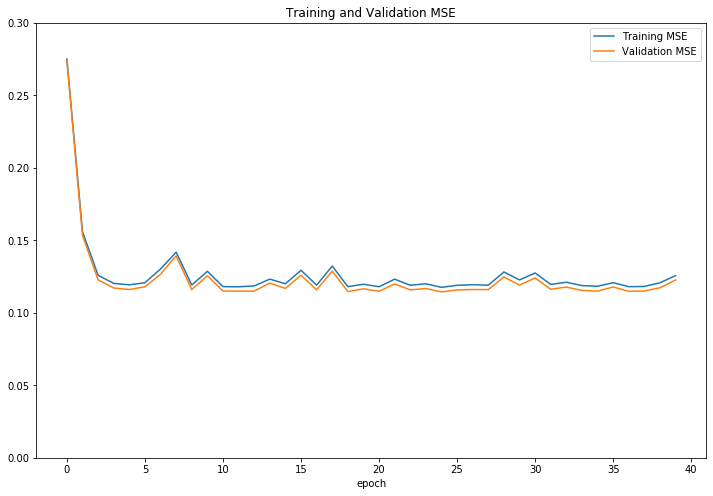

In [251]:
plt.figure(figsize=(12, 8))
plt.plot(MSE_train, label='Training MSE')
plt.plot(MSE_test, label='Validation MSE')
plt.ylim([0, 0.3])
plt.legend(loc='upper right')
plt.title('Training and Validation MSE')
plt.xlabel('epoch')
plt.show()

In [259]:
print("Min training set MSE: ", min(MSE_train), ' at epoch ', MSE_train.index(min(MSE_train)))
print("Min test set MSE: ", min(MSE_test), ' at epoch ', MSE_test.index(min(MSE_test)))

Min training set MSE:  0.11757797  at epoch  24
Min test set MSE:  0.11444958  at epoch  24


Beats mean model MSE of 0.11564349413951246 just by a bit :D.

Let's check the best description there is.

In [264]:
def get_predictions(estimator, input_fn):
  return [x['predictions'][0] for x in estimator.predict(input_fn=input_fn)]

In [271]:
predictionsList = get_predictions(estimator, predict_test_input_fn)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-13280


INFO:tensorflow:Restoring parameters from /tmp/tmphqqy5ryu/model.ckpt-13280


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


In [272]:
predictionsList[:5]

[4.1072984, 4.008201, 4.082131, 4.0444546, 4.294516]

In [273]:
maxPrediction = predictionsList.index(max(predictionsList))

In [274]:
maxPrediction

125

In [299]:
max(predictionsList)  # over 5, that should be a really good book

5.125785

In [284]:
bestDescriptionEvah = test_df.reset_index(drop=False).iloc[maxPrediction,:]
bestDescriptionEvah[1]

'Sejarah mencatatkan, para sahabat banyak belajar berkenaan masalah agama dan hukum fikah daripada Aisyah. Ini kerana, pengetahuannya sangat luas dalam bidang itu. Aisyah menjadi sumber yang tidak diragukan dalam bidang ilmu pengetahuan, masalah agama serta Quran dan sunah. Di samping itu, beliau diketahui sangat berhati-hati semasa mengulas sebarang masalah peribadi. Di samping mengetahui banyak rahsia peribadi Nabi Muhammad, Aisyah juga mengisahkan banyak hadis yang didengarnya daripada beliau secara langsung.Buku ini adalah karya Sulaiman an-Nadawi, ulama terkemuka dari Universiti Nadwatul Ulama. Beliau adalah guru kepada Syeikh Abul Hasan Ali al-Hasani an-Nadawi. Keistimewaan buku ini terletak pada kajiannya berkenaan pengetahuan serta sejarah hidup Aisyah Ummul Mukminin. Aisyah adalah sumber rujukan intelektual para sahabat terkemuka.Sejarah mencatatkan, para sahabat banyak belajar berkenaan masalah agama dan hukum fikah daripada Aisyah. Ini kerana, pengetahuannya sangat luas dala

In [288]:
bestBookEvah = df[df['book_desc']==bestDescriptionEvah[1]]
bestBookEvah

,book_authors,book_desc,book_edition,book_format,book_isbn,book_pages,book_rating,book_rating_count,book_review_count,book_title,genres,image_url
36030,Sulaiman an-Nadawi,"Sejarah mencatatkan, para sahabat banyak belaj...",NaN,Hardcover,9.78979E+12,468 pages,4.16,286,28,Aisyah the True Beauty,Religion|Islam|Nonfiction|Biography,https://images.gr-assets.com/books/1208520246l...


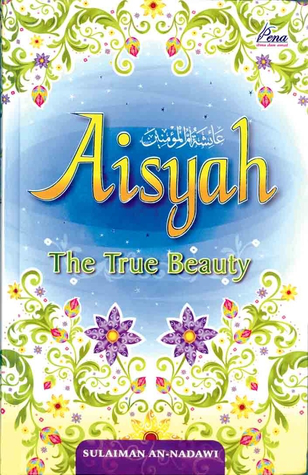

In [298]:
img = Image.open(IMAGES_PATH + str(bestBookEvah.index[0]) + '.jpg') 
img